In [1]:
# 라이브러리
import os
import pandas as pd
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import torch
import random

CSV 로드

In [2]:
# hotel폴더의 archive폴더에 있는 CSV로드
import easydict
args = easydict.EasyDict()

args.default_path = './archive/hotel_bookings.csv'

# 데이터 분석을 위한 변수들
args.random_state = 21

# Load hotel Data

In [3]:
plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv(args.default_path)
df.shape

(119390, 32)

In [5]:
hotel_counts = df['hotel'].value_counts()
print(hotel_counts)

hotel
City Hotel      79330
Resort Hotel    40060
Name: count, dtype: int64


In [6]:
total_of_special_requests_counts = df['total_of_special_requests'].value_counts()
print(total_of_special_requests_counts)

total_of_special_requests
0    70318
1    33226
2    12969
3     2497
4      340
5       40
Name: count, dtype: int64


In [7]:
customer_type_counts = df['customer_type'].value_counts()
print(customer_type_counts)

customer_type
Transient          89613
Transient-Party    25124
Contract            4076
Group                577
Name: count, dtype: int64


In [8]:
stays_in_weekend_nights_counts = df['stays_in_weekend_nights'].value_counts()
print(stays_in_weekend_nights_counts)

stays_in_weekend_nights
0     51998
2     33308
1     30626
4      1855
3      1259
6       153
5        79
8        60
7        19
9        11
10        7
12        5
13        3
16        3
14        2
19        1
18        1
Name: count, dtype: int64


결측치 확인

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [10]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [11]:
# df['company'].unique()
# df['agent'].unique()
# df['country'].unique()
df['children'].unique()

array([ 0.,  1.,  2., 10.,  3., nan])

is_canceled
0    62.958372
1    37.041628
Name: proportion, dtype: float64


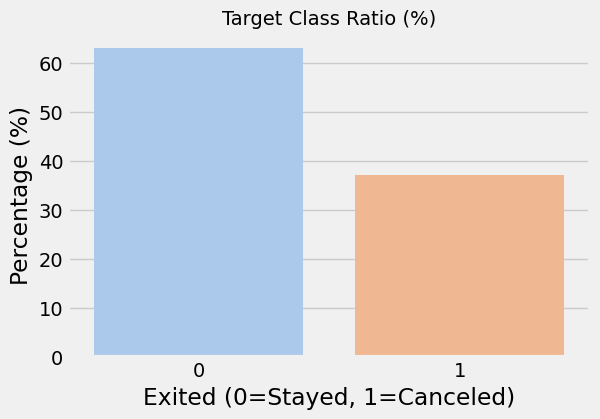

In [12]:
#타깃 불균형 확인 -> 타깃 불균형치 높음(0: 65%, 1: 35%) ==> class_weight, SMOTE 등 써야 함
target_ratio = df['is_canceled'].value_counts(normalize=True) * 100
print(target_ratio)

plt.figure(figsize=(6,4))
sns.barplot(x=target_ratio.index, y=target_ratio.values, palette='pastel')
plt.title('Target Class Ratio (%)', fontsize=14)
plt.xlabel('Exited (0=Stayed, 1=Canceled)')
plt.ylabel('Percentage (%)')
plt.show()

# 칼럼 설명


## ✅ 수치형 (Numeric Features)
### 연속형 + 이산형 숫자들
- lead_time
- arrival_date_year
- arrival_date_day_of_month    → 도착년도 월일을 범주형의 예약날짜, 확정일 경과시간과 비교할것
- stays_in_weekend_nights
- stays_in_week_nights  → 주중과 주말 숙박일 수를 합쳐 하나의 피쳐 생성
- adults
- children
- babies   → 어른과 어린이 수 와 함깨 합쳐 하나의 피쳐 생성
- is_repeated_guest   →  첫방문과 재방문 여부
- previous_cancellations   →  이전 예약 취소 횟수
- previous_bookings_not_canceled   →  취소하지 않은 횟수
- booking_changes    →  예약 변경 횟수
- days_in_waiting_list   →  대기 리스트에 있는 일수
- adr (평균 일일 요금)
- required_car_parking_spaces   →  요청 주차공간 (가족수와 비교할것 가족수가 많으면 요구 주차대수 늘어날 것으로 보임)
- total_of_special_requests   →  특별 요청 개수 (특별 요청이 많을수록 추가 비용 발생 가능성 따라서 예약비용이 올라갈 것으로 보임)

## ✅ 범주형 (Categorical Features)
### 문자열 또는 ID 같은 비연속형

- hotel   →  도시형, 시골형
- arrival_date_month   →  월형태이므로 순서형으로 변환(도착년, 월 합칠것)
- meal   →  식사 포함 여부(금액에 영향을 줄 것으로 보임)
- reserved_room_type   →  예약 객실 유형
- assigned_room_type   →  실제 받은 객실 유형 (예약 객실 유형과 비교할 것)
- deposit_type   →  보증금 유형 (보증금 유형에 따라 취소 가능성 다를 것, 비쌀수록 안하겠지)
- customer_type   →  단기인가 장기인가(예약 형태와 관련)

## 불필요한 컬럼
- deposit_type 	사실상 호텔 금액에 포함되는 비용 → 예약 취소에 영향을 줄것으로 보이지 않음
- company	결측치 多 (has_company 피처 생성 후 제거)
- agent 	결측치 多 (has_agent 피처 생성 후 제거)
- reservation_status,reservation_status_date	두 컬럼은 모델이 예측해야 할 - 결과와 너무 직접적으로 연결되어 있어 예측 변수로서의 의미가 없습니다.
- assigned_room_type	 ‘체크인’한 후에 결정되는 데이터라서, 취소한 사람들의 값은 없음. 
- assigned_room_type	 ‘체크인’한 후에 결정되는 데이터라서, 취소한 사람들의 값은 없음. 
- children, babies	adult랑 합친 후 제거해도 됨(family). 예약 취소와 직접적인 연관이 없는듯
- arrival_date_full 	2017-8-1   이런형태. 테스트 데이터 나눌려고 만든 컬럼이라 제거해야함

수치형 데이터 확인

In [13]:
df_tmp1 = df.drop(['agent', 'company', 'arrival_date_week_number', 'country', 'market_segment', 'distribution_channel'], axis=1)
df_tmp1.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


- is_canceled
평균: 0.37 → 전체 예약 중 37%가 취소됨
0/1 값 → 이진 타겟 변수

- lead_time (리드타임)
평균: 104일, 최대: 737일 → 예약 후 도착까지 걸린 일수
긴 리드타임은 취소 가능성이 커질 수 있음

- arrival_date_year / arrival_date_day_of_month
연도: 2015~2017 데이터
날짜는 1~31일 분포

- stays_in_weekend_nights / stays_in_week_nights
평균 주말 숙박: 0.9박, 주중 숙박: 2.5박
최대 19박(주말), 50박(주중) → 비정상적으로 긴 체류는 아웃라이어 가능

- adults / children / babies
평균 성인: 1.85명, 아이: 0.10명, 아기: 0.007명
children 결측치 있었음 (119386/119390) → 4건 NaN

- is_repeated_guest
평균 0.031 → 약 3%만 재방문 고객

- previous_cancellations / previous_bookings_not_canceled
일부 고객은 최대 26번 취소, 72번 예약 경험 있음 → extreme outlier

- booking_changes
예약 변경 평균 0.22회, 최대 21회 → outlier 가능

- days_in_waiting_list
평균 2.3일, 최대 391일 → 어떤 예약은 1년 넘게 대기 상태

- adr (평균 일일 요금)
평균 101.8, 최대 5400 → 극단치 있음 → 이상치 처리 필요
최소 -6.38 → 음수 요금 이상치 존재!

- required_car_parking_spaces
평균 0.06 → 대부분 주차공간 필요 없음
total_of_special_requests

- total_of_special_requests
평균 0.57개, 최대 5개 → 고객 맞춤 요청 (예: 침대 추가, 조식 등)

adr 음수 값 → 이상치 처리 필요

stays_in_week_nights 50박, adults 55명 → 비정상치 제거 필요

children NaN → 소수라서 median/0으로 대체 가능 (나이를 의미하는 것으로 보임)

days_in_waiting_list 최대 391일 → 분석 목적 따라 trim 필요

범주형 데이터 확인

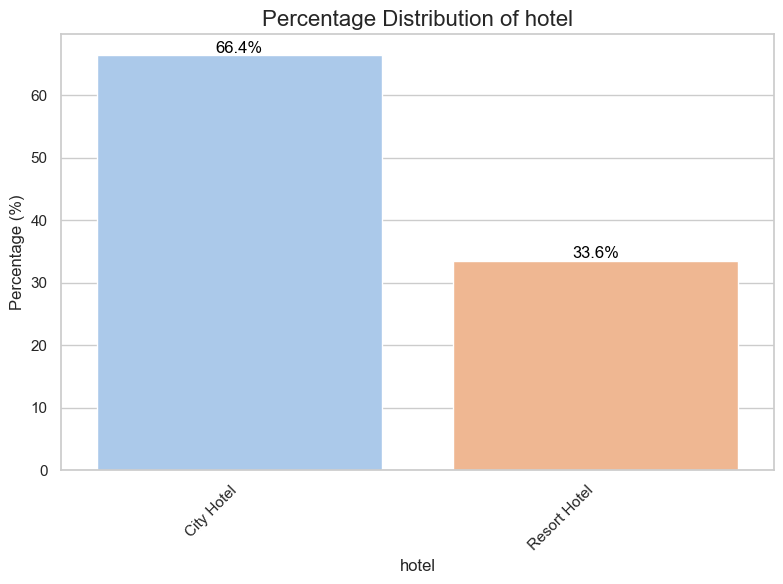

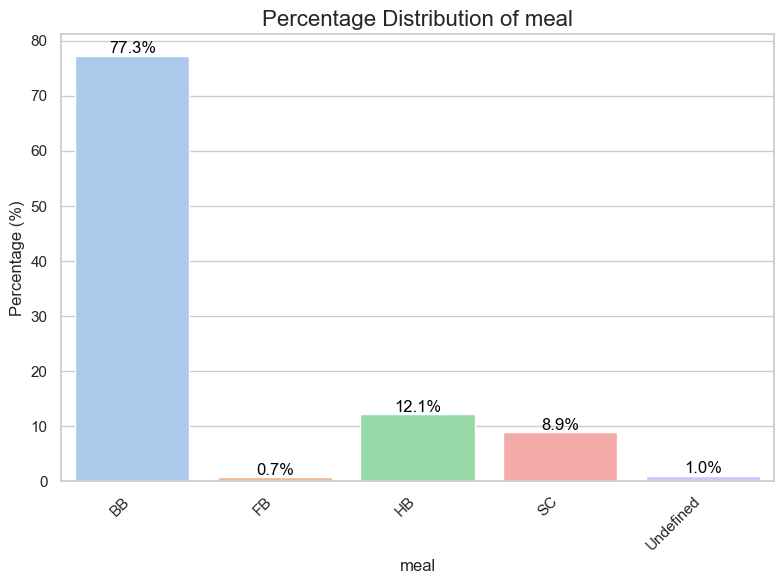

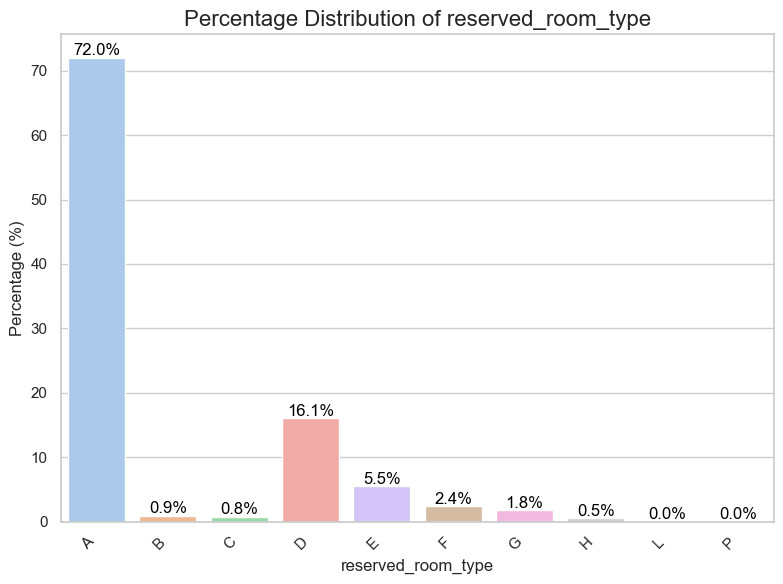

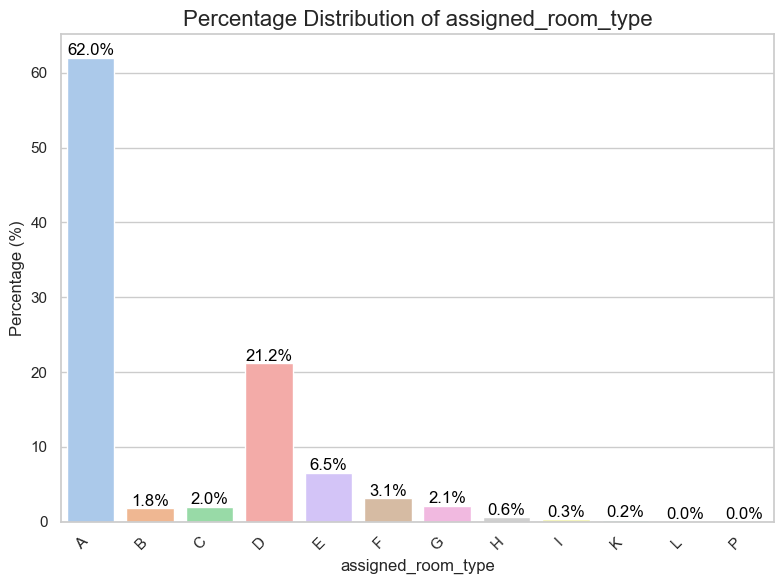

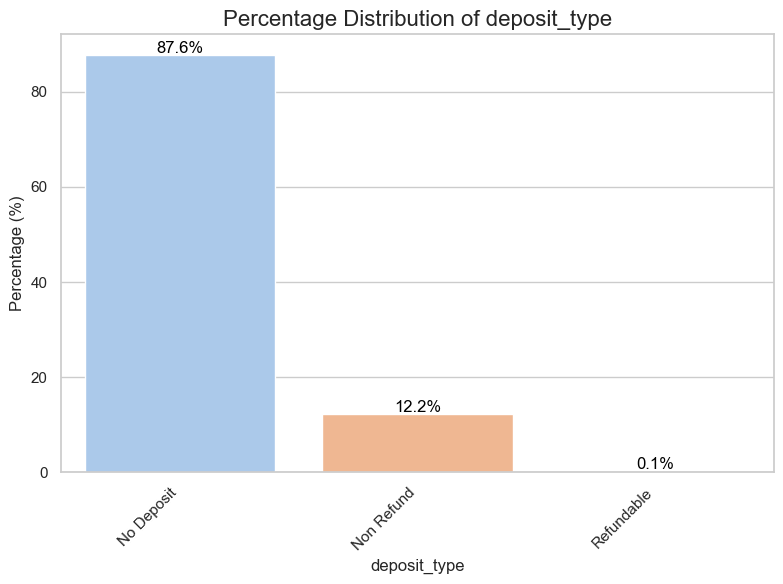

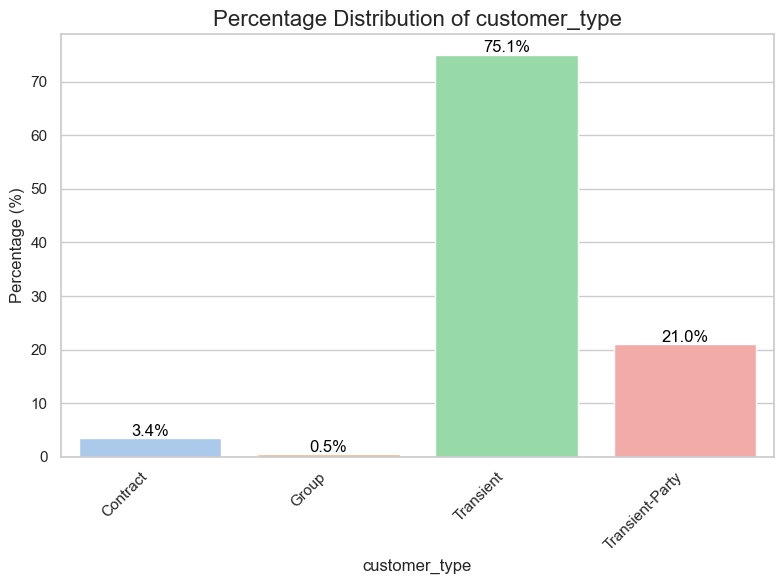

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it's already loaded
# df = pd.read_csv('your_data.csv') 

# Set the visualization style
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (8, 6)

# List of categorical columns to plot
cat_cols = ['hotel', 'meal', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

# Loop through each categorical column and create a bar plot
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    
    # Calculate the percentage distribution of each category
    dist = df[col].value_counts(normalize=True).sort_index() * 100
    
    # Create the bar plot using Seaborn
    ax = sns.barplot(x=dist.index, y=dist.values, palette='pastel')
    
    # Set plot titles and labels
    plt.title(f'Percentage Distribution of {col}', fontsize=16)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xlabel(col, fontsize=12)
    
    # Add percentage labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 5), textcoords='offset points')
    
    # Rotate x-axis labels if they are long
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

- city : resort = 66 : 33
월은 계절로 묶으면 좋아보임
식사 제공 - 대부분 BB 조식만 제공
HB : 저녁, 조식
FB : 3식
SC : 식사 미포함

- 예약 Room type
A : 72%
D : 16%
E : 5%
F : 2.4%
G : 1.8%
정리를 하거나 날리는게 좋아보임, 혹은 금액과비교

- 제공 받은 방
A : 62%
D : 21%
E : 6.5%
F : 3.1%
G : 2.1%
C : 2%
B : 1.8%
예약한 방과 제공받은 방의 차이를 비교해볼것

0.* 타입은 정리하고 최빈값으로 체우기

- 보증금
없음 : 안돌려줌 = 87% : 12:
0.1퍼는 없음으로 채우기

- 고객유형
"Transient" (단기 투숙객, 개인),
"Contract" (계약 고객, 기업 등),
"Group" (단체 고객) : 정리 필요,
"Transient-Party" (일부 단체와 함께 예약한 단기 고객)

- 예약 상태
체크 아웃 : 취소 : 노쇼 = 63: 36 : 1
노쇼는 취소랑 합칠것


- 예약 상태 날짜는 월단위로 잘라서 정리할것


각 범주형 데이터를 취소 여부와 비교해봄

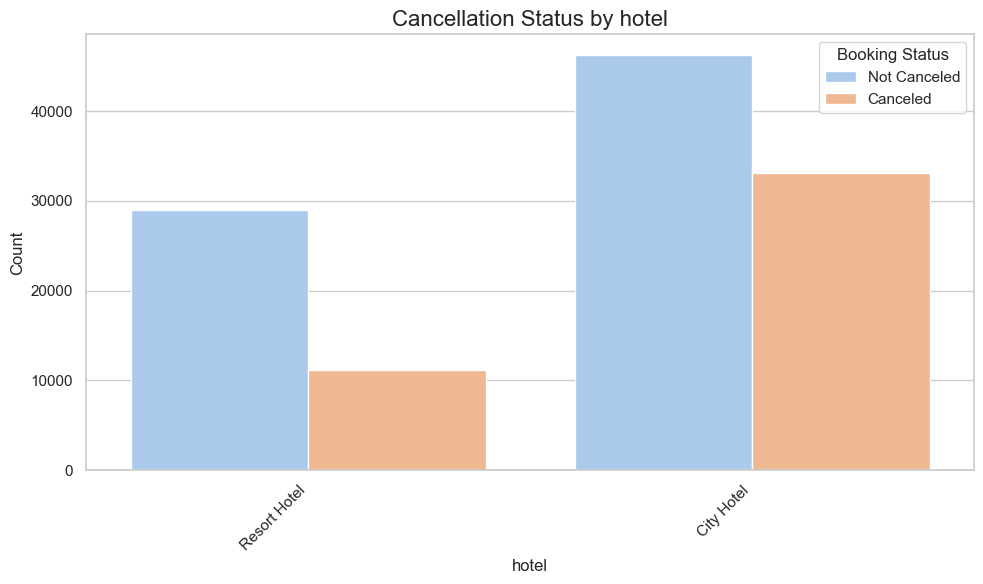

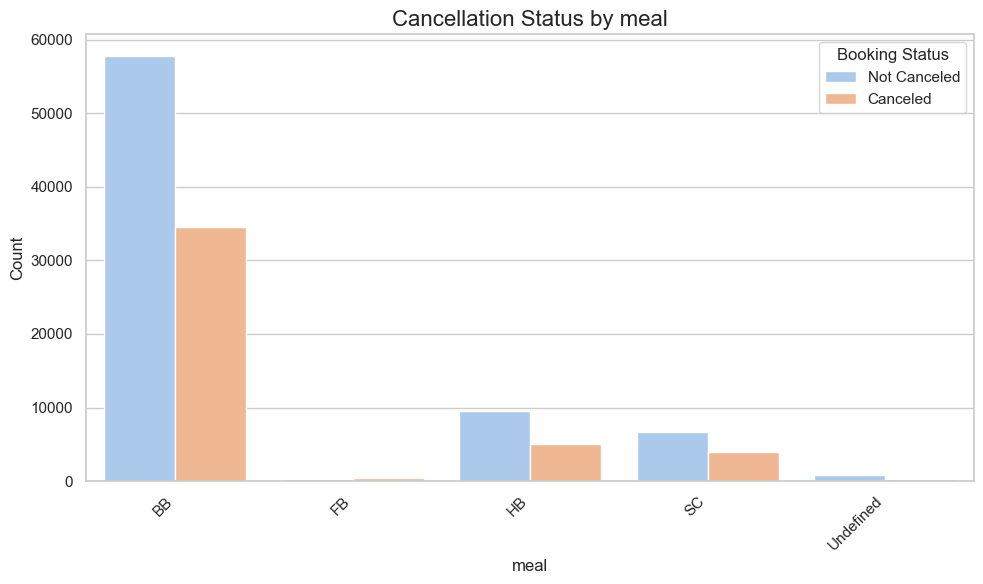

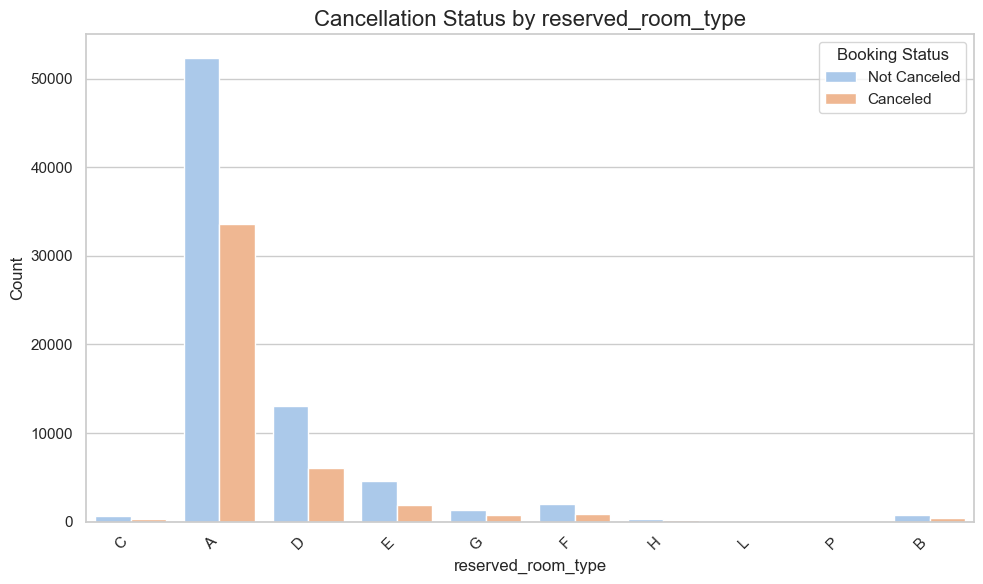

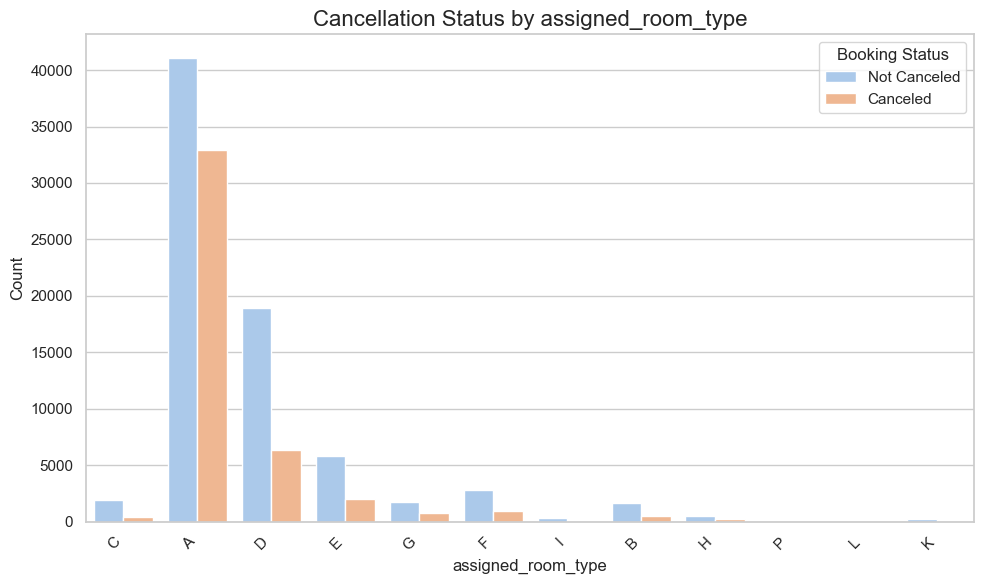

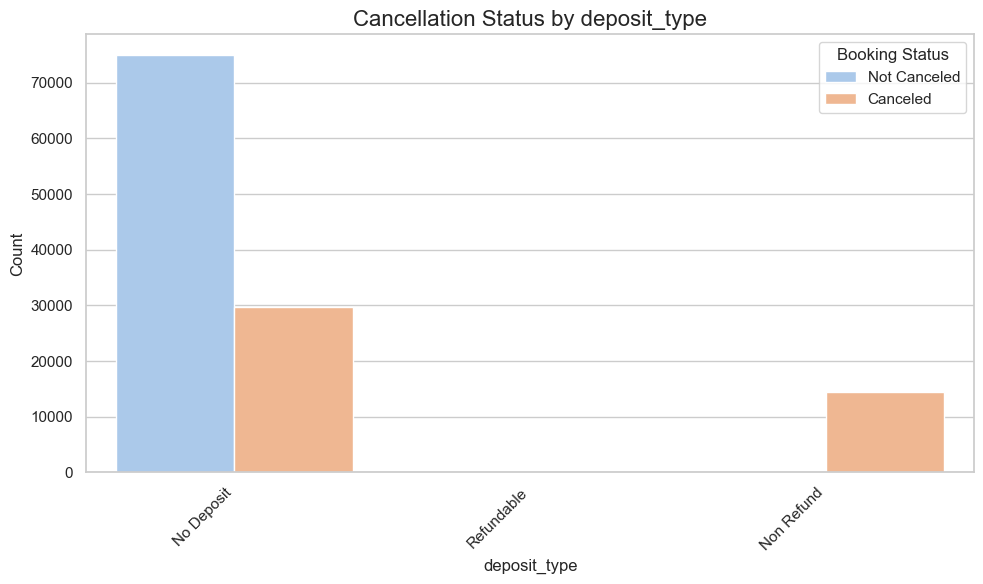

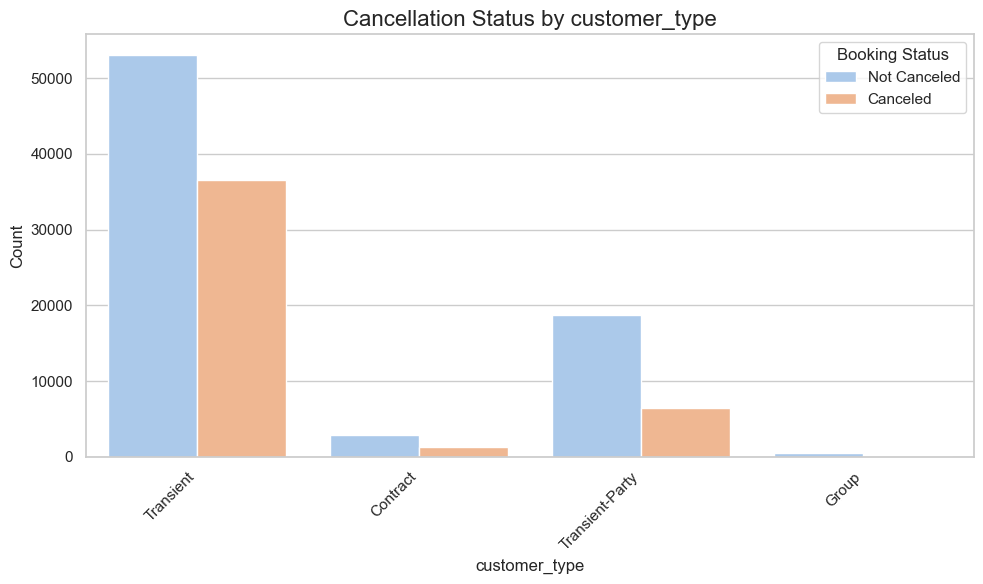

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it's already loaded
# df = pd.read_csv('your_data.csv') 

# Set the visualization style
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (10, 6)

# List of categorical columns to analyze
cat_cols = ['hotel', 'meal', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

# Loop through each categorical column and create a grouped bar plot
for col in cat_cols:
    plt.figure(figsize=(10, 6))

    # Calculate the count of cancellations and non-cancellations for each category
    # 'hue' is used to differentiate between 'is_canceled' values
    sns.countplot(data=df, x=col, hue='is_canceled', palette='pastel')
    
    # Set plot titles and labels
    plt.title(f'Cancellation Status by {col}', fontsize=16)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(col, fontsize=12)
    
    # Customize the legend labels
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.gca().legend(handles=handles, labels=['Not Canceled', 'Canceled'], title='Booking Status')
    
    # Rotate x-axis labels if they are long
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

season  : 계절별 취소율은 거의 비슷한 값을 가짐 버림
month season이랑 
 meal은 0.7%율로 모든 3식을 제공하는 곳에서 취소율이 높음.....
그 외에는 취소율이 비슷하여 버릴지 말지 고민해야 할거같음

예약한 방과 제공받은 방의 예약률이 다르게 나타남 하나로 엮어서 머신러닝을 시키는게 좋아보임
방이 바뀐경우 취소율이 낮음 조금 다른 결과가 나오는 것으로 보임

보증금 좋아보임


애초에 취소율은 볼......... 필요가 있나....?
취소를 한것과 비교하면 양의 상관계수가 아닐까

겨울에 예약 취소율이 높음 월단위로 추출하는것이랑 month season과 차이가 나는 이유가 뭘까.

num_cols = [
    'lead_time',
    'arrival_date_year',
    'arrival_date_day_of_month',
    'stays_in_weekend_nights',
    'stays_in_week_nights',  # → 합쳐 total_stays로 만들어도 가능
    'adults',
    'children',
    'babies',                # → 합쳐 total_guests로 만들어도 가능
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests'
]

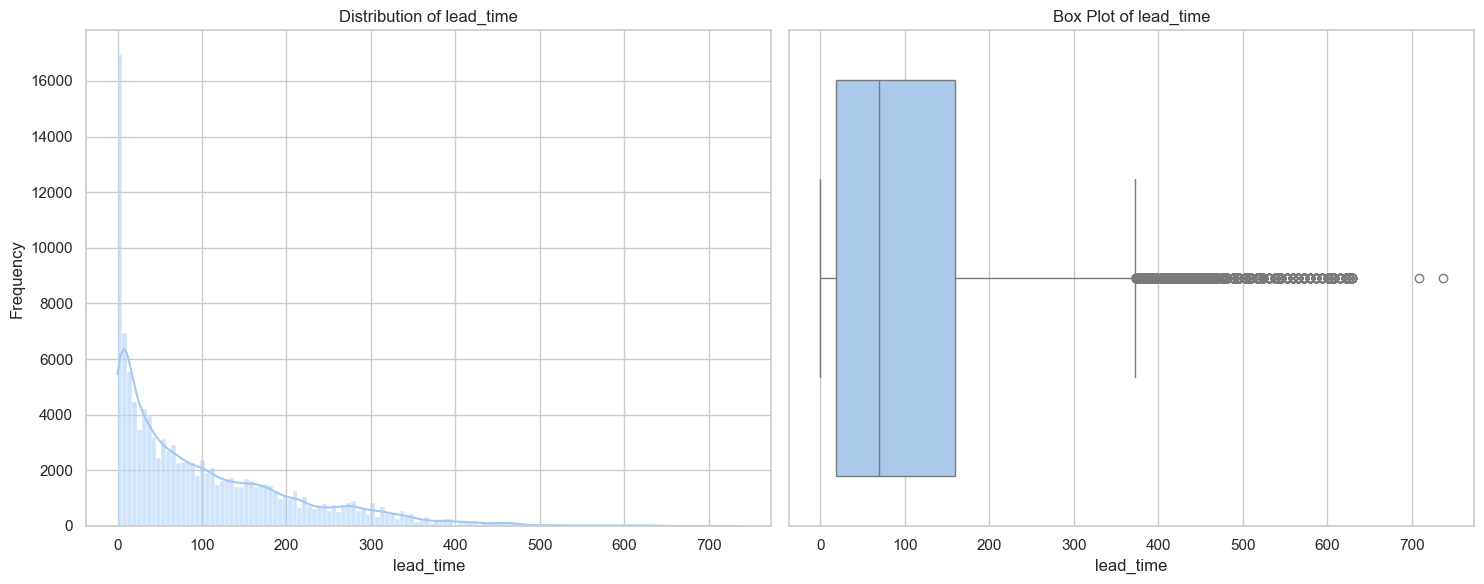

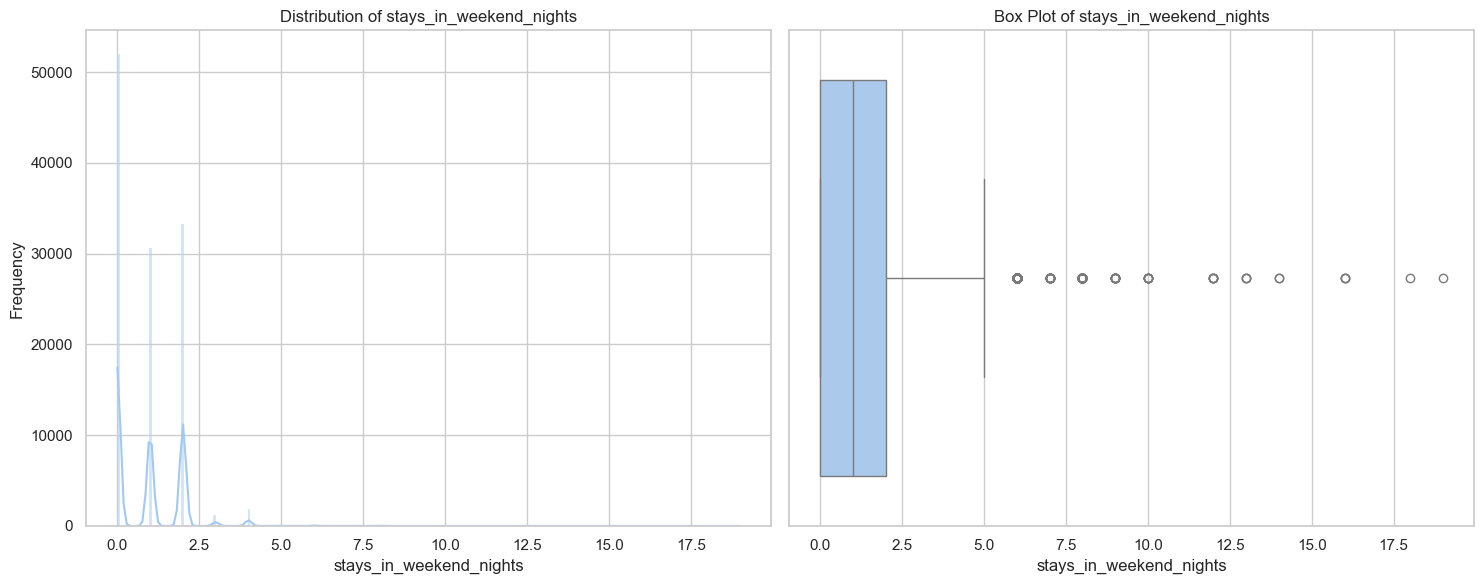

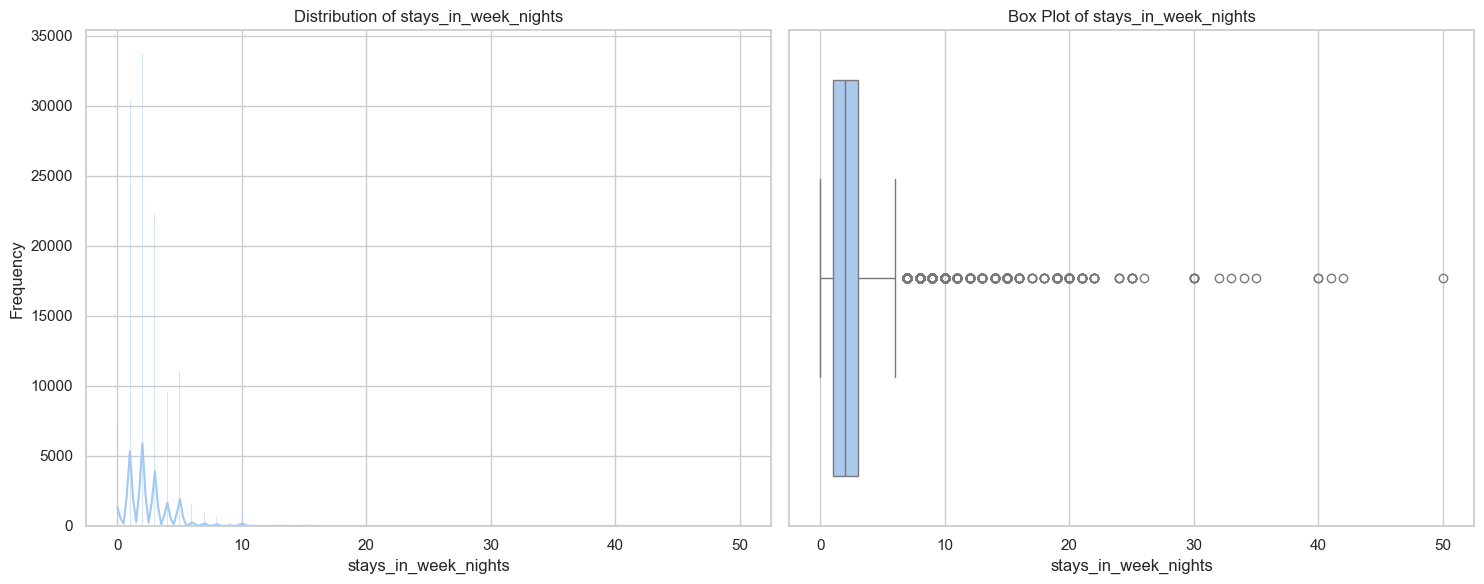

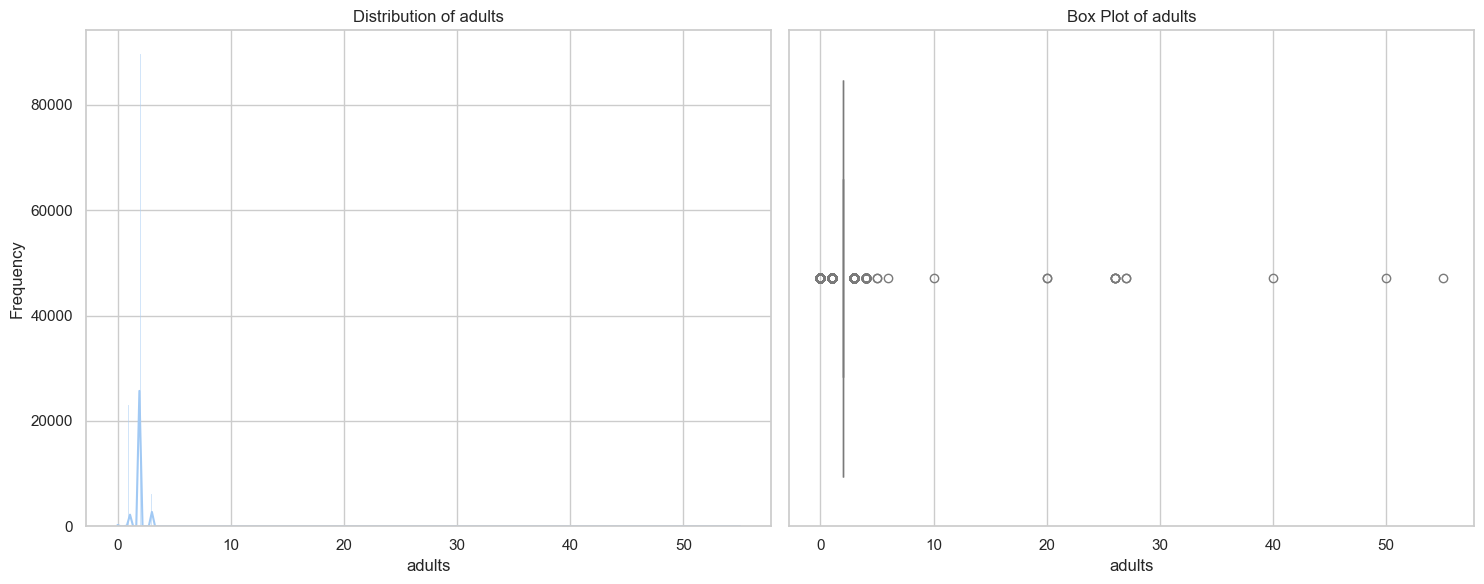

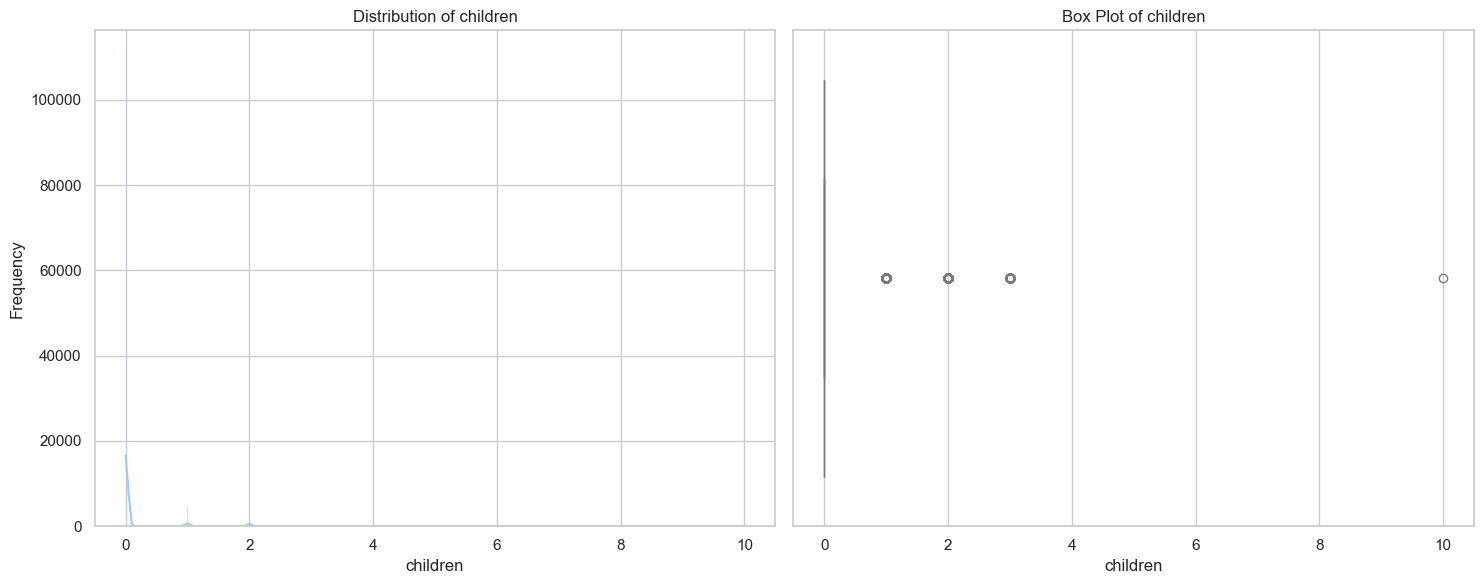

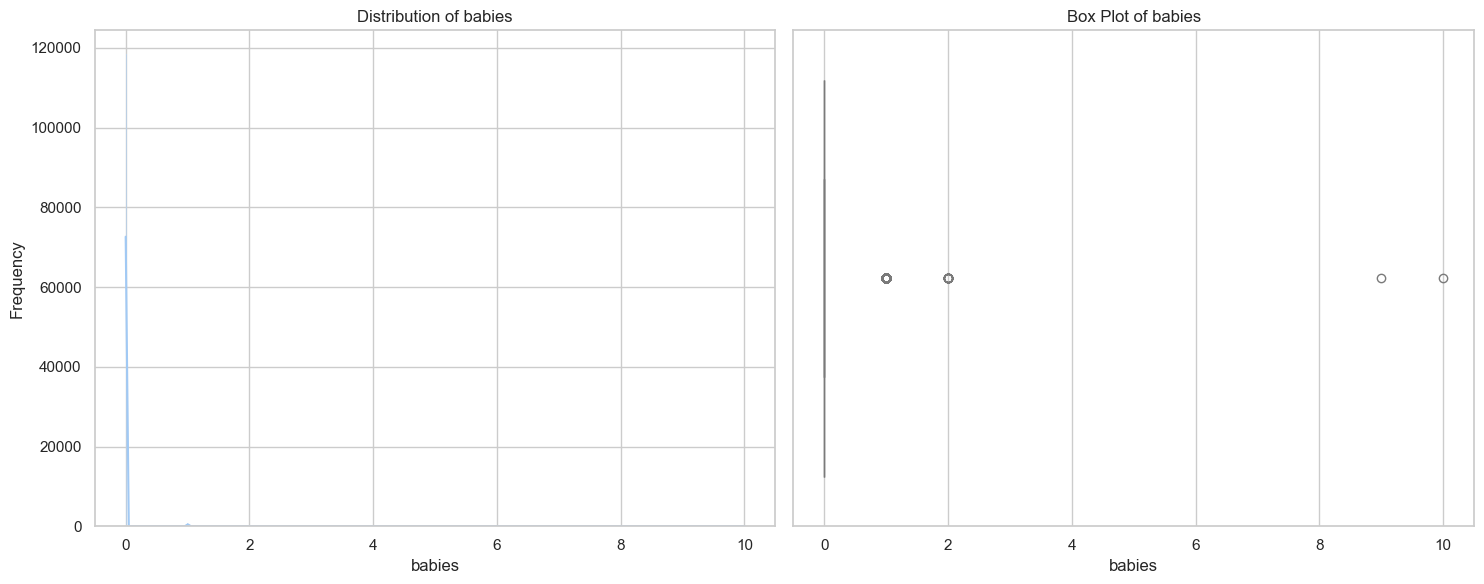

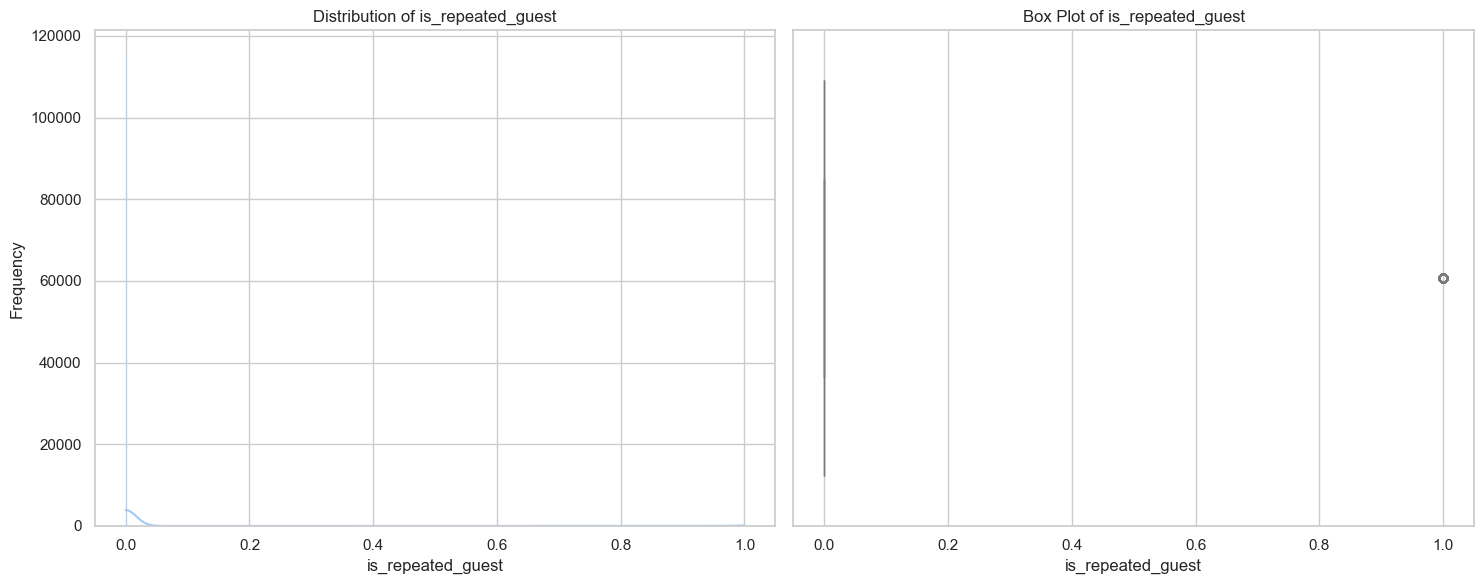

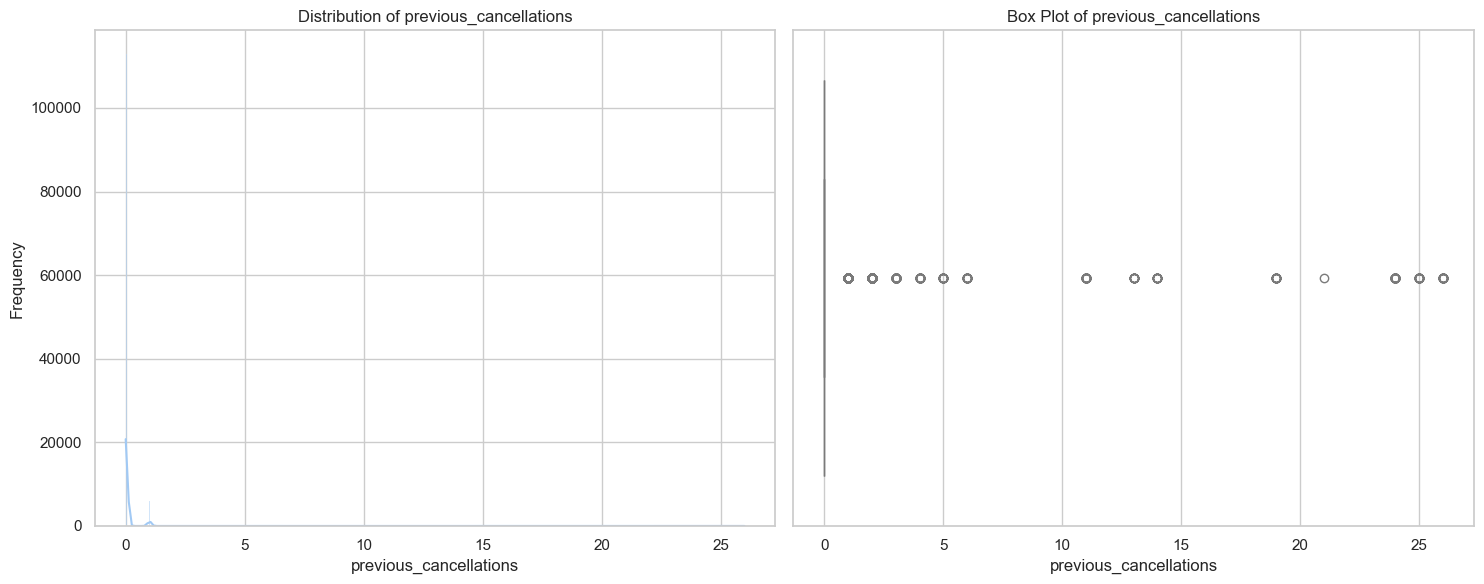

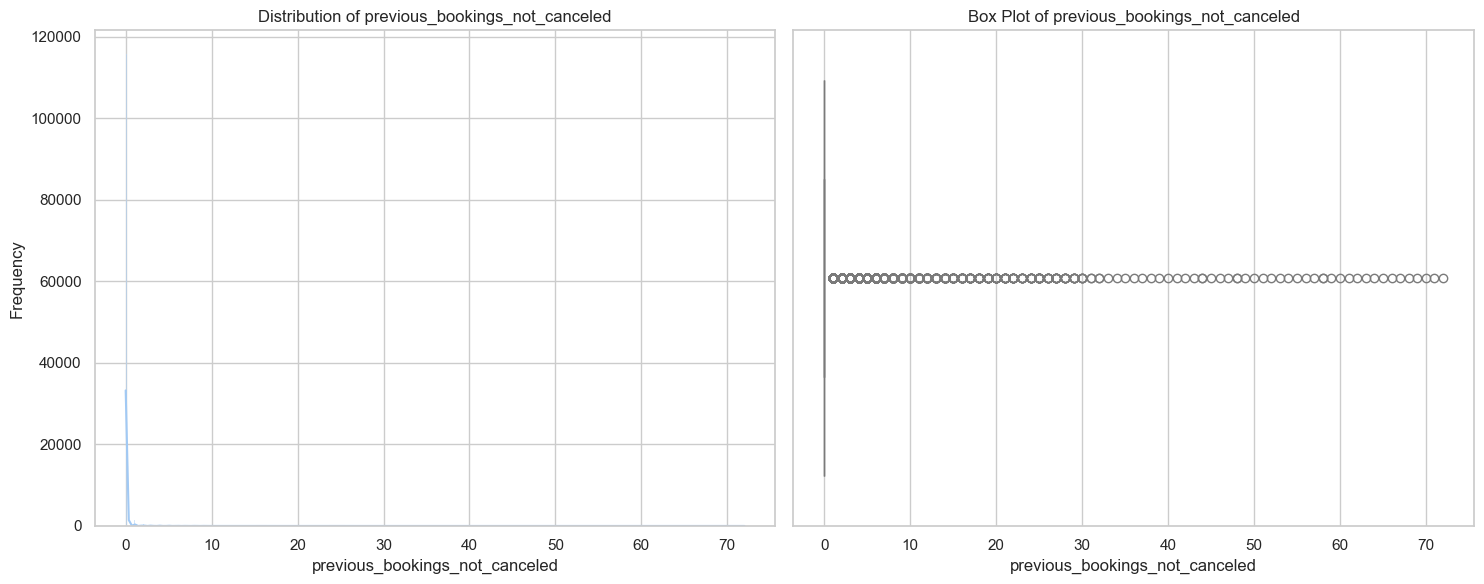

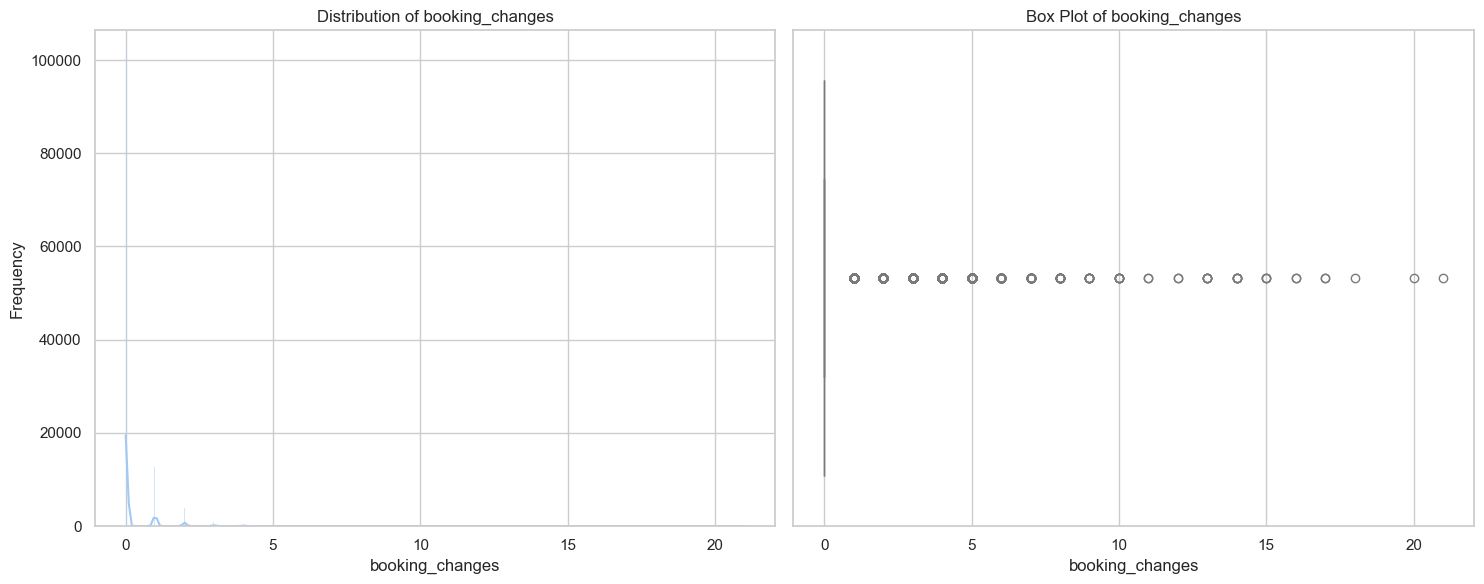

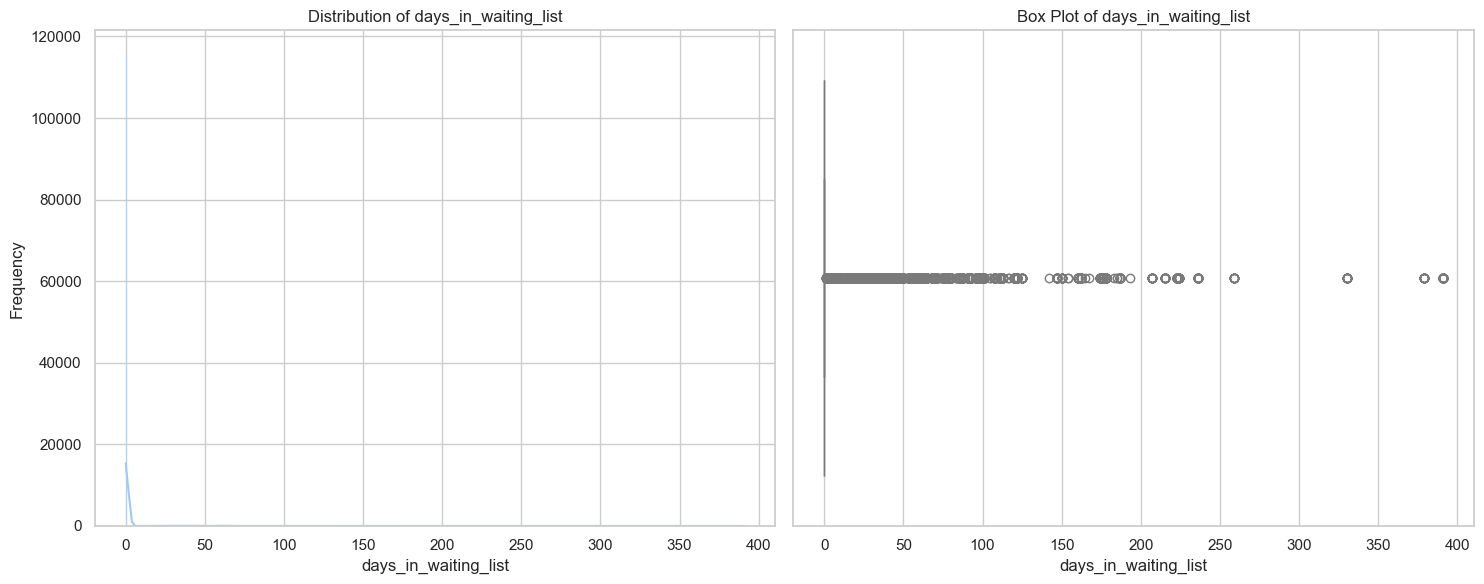

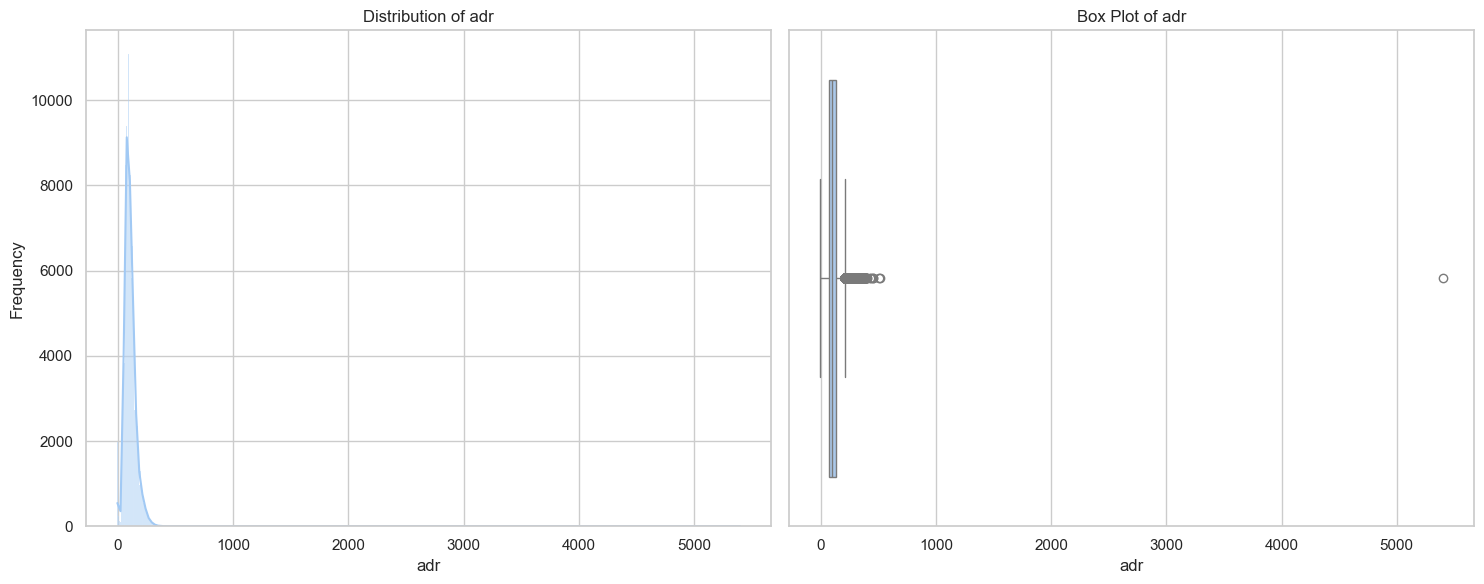

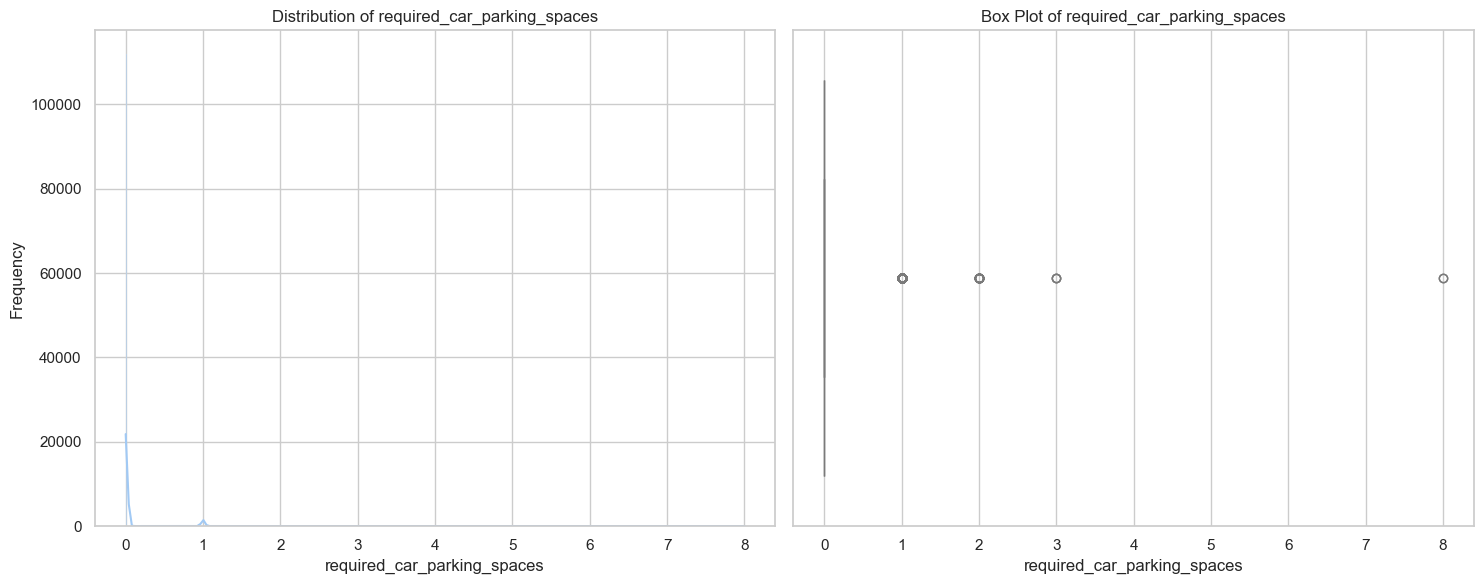

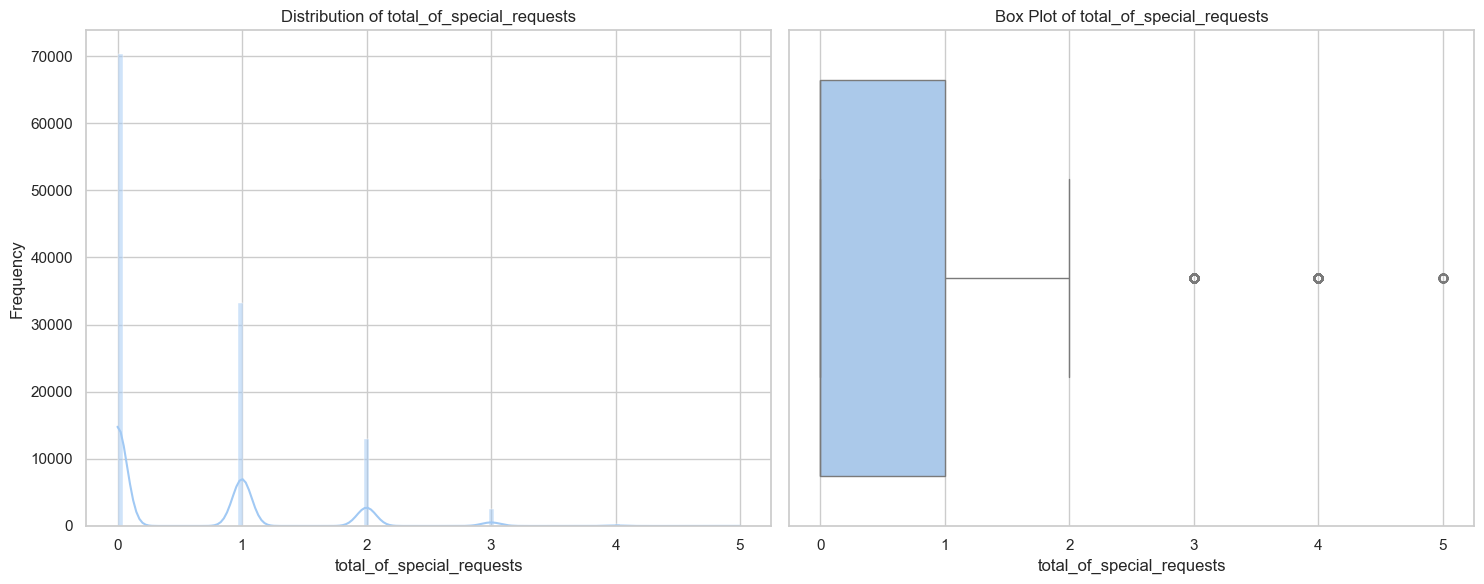

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and it's already loaded
# df = pd.read_csv('your_data.csv') 

# Setting plot style
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (10, 5)

# List of numerical columns to plot
num_cols = [
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests'
]

# Loop through each numerical column and create a histogram and a box plot
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot a histogram to show the distribution
    sns.histplot(data=df, x=col, kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Plot a box plot to show outliers
    sns.boxplot(data=df, x=col, ax=axes[1])
    axes[1].set_title(f'Box Plot of {col}')
    axes[1].set_xlabel(col)
    
    plt.tight_layout()
    plt.show()

일부 그래프 형태가 이상하게 찍힌 것을 보아 이상치가 있을 것으로 보임

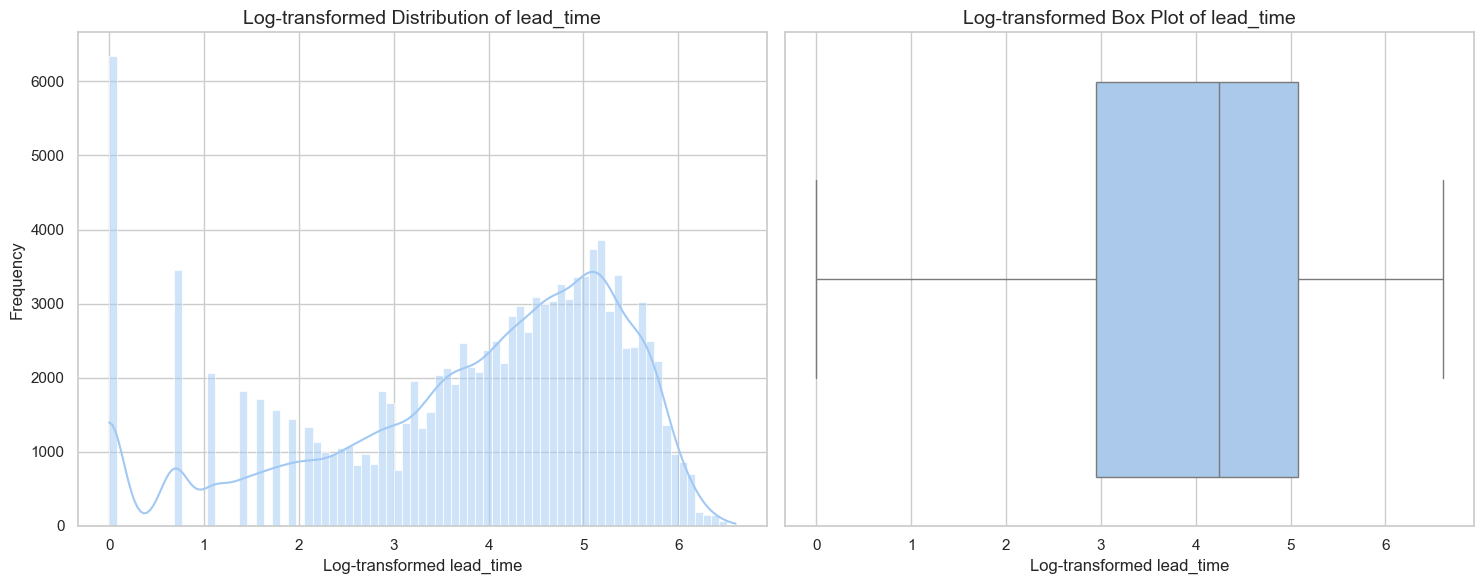

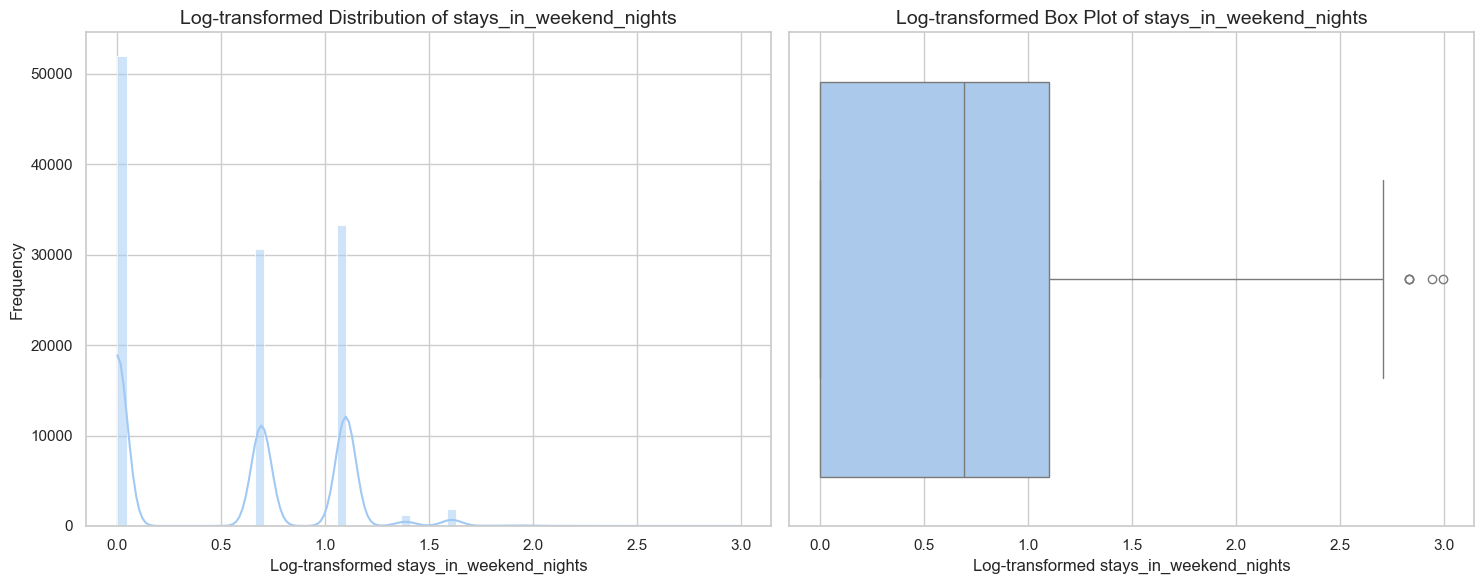

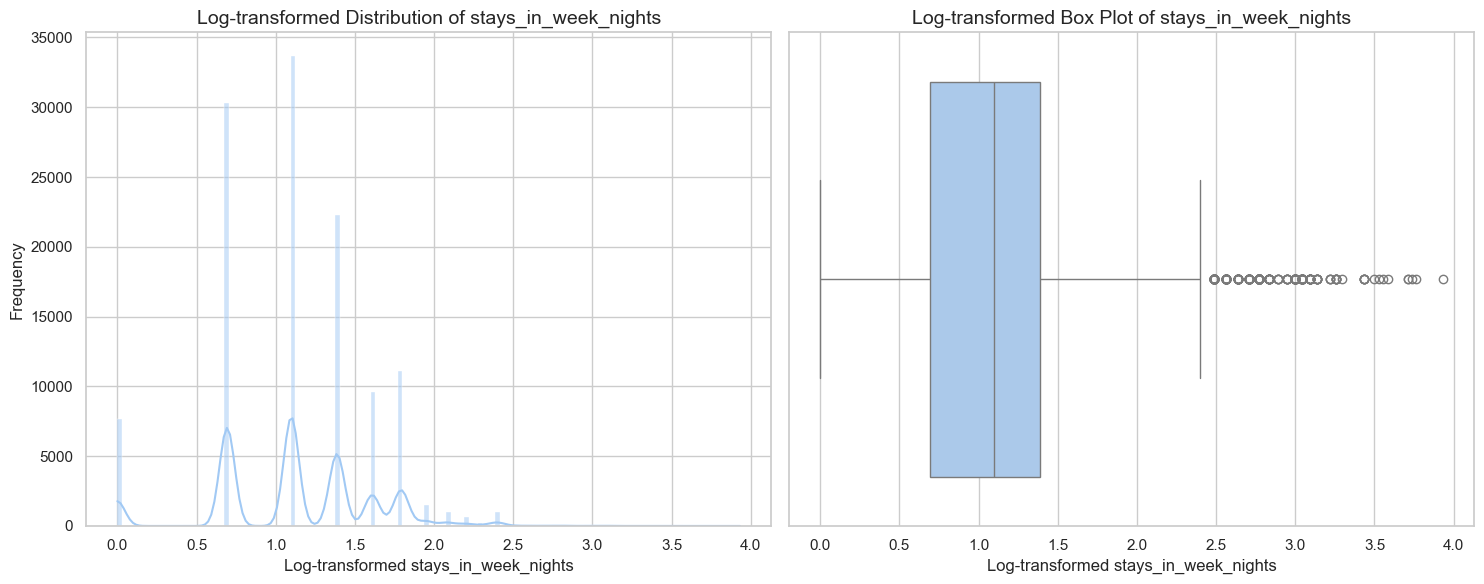

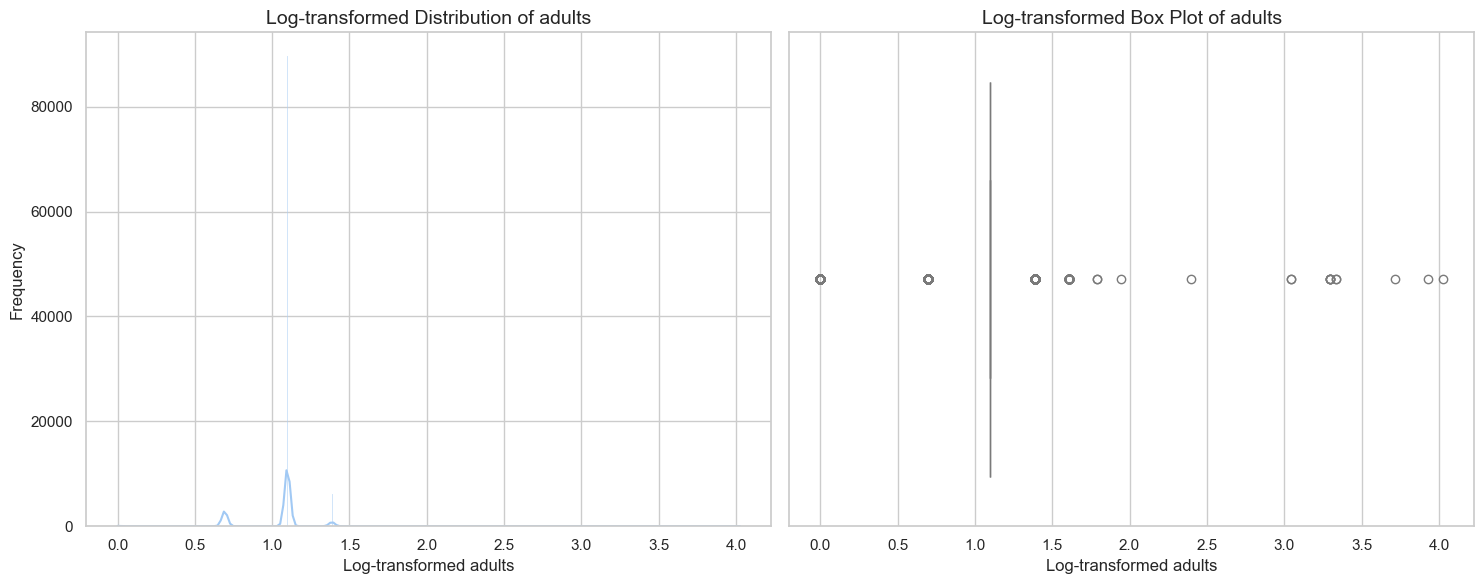

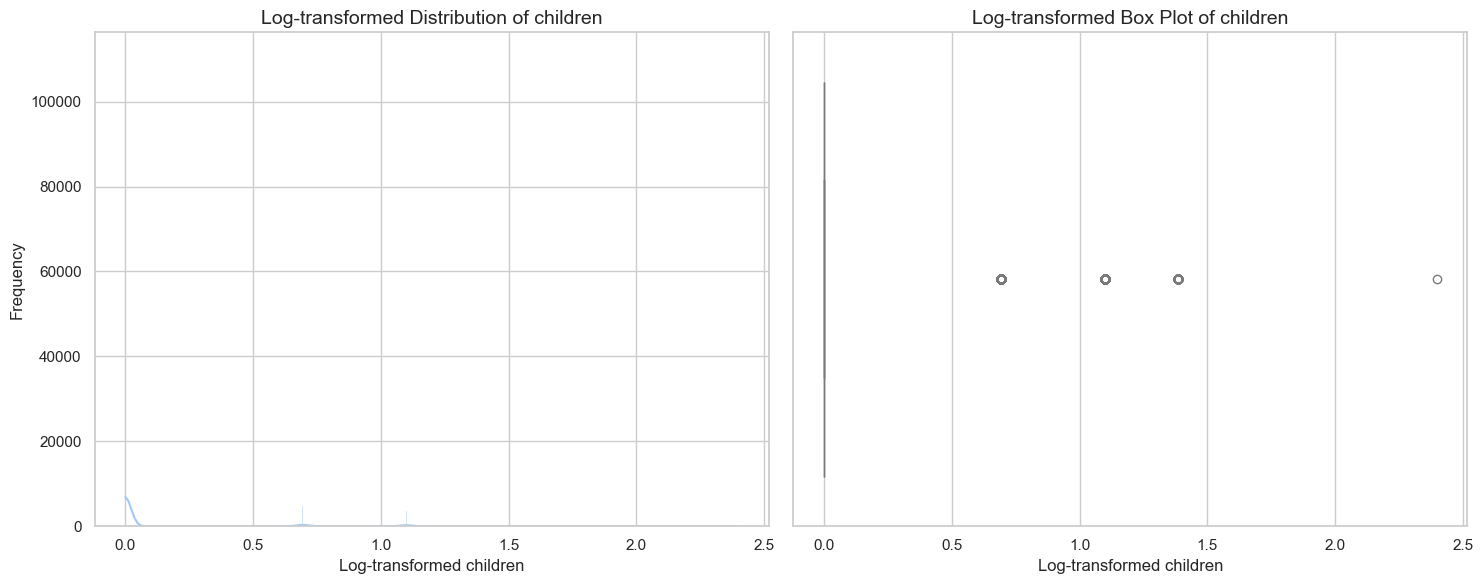

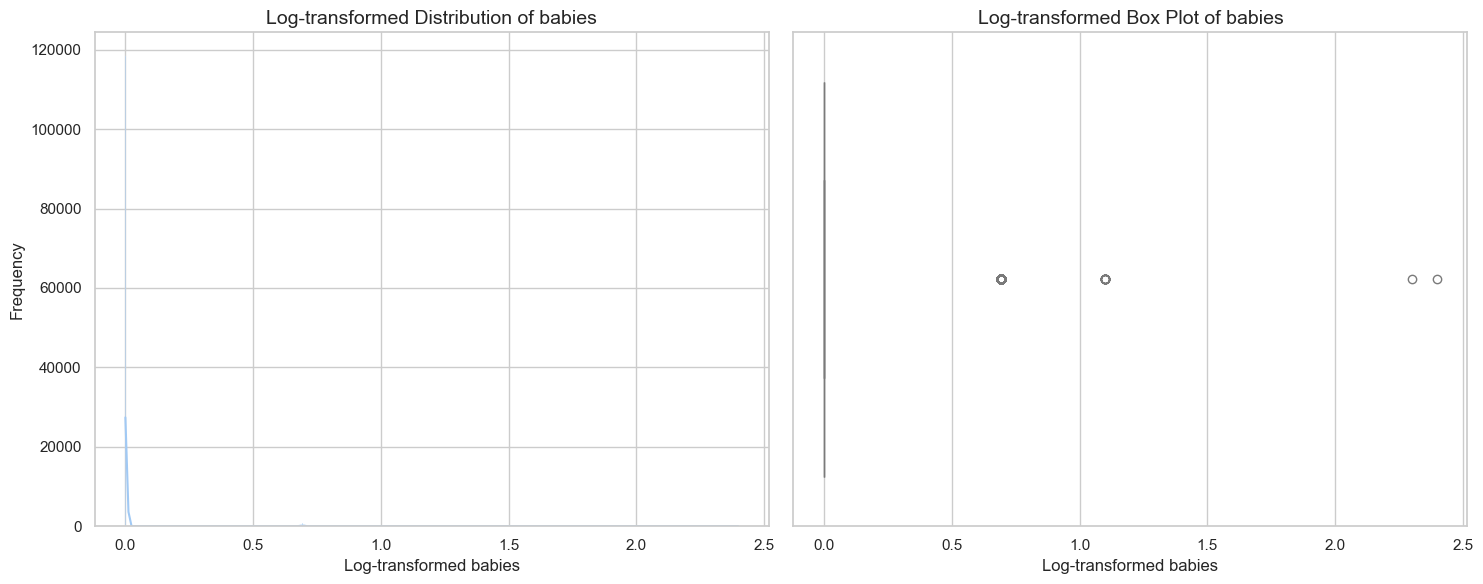

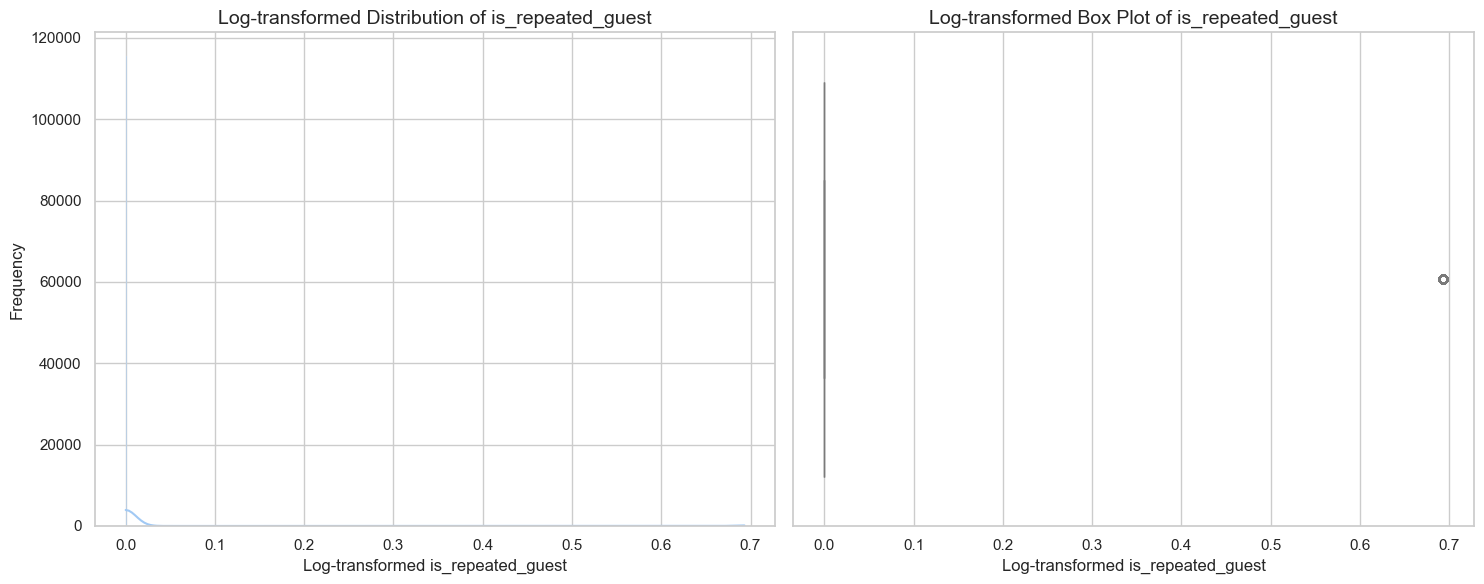

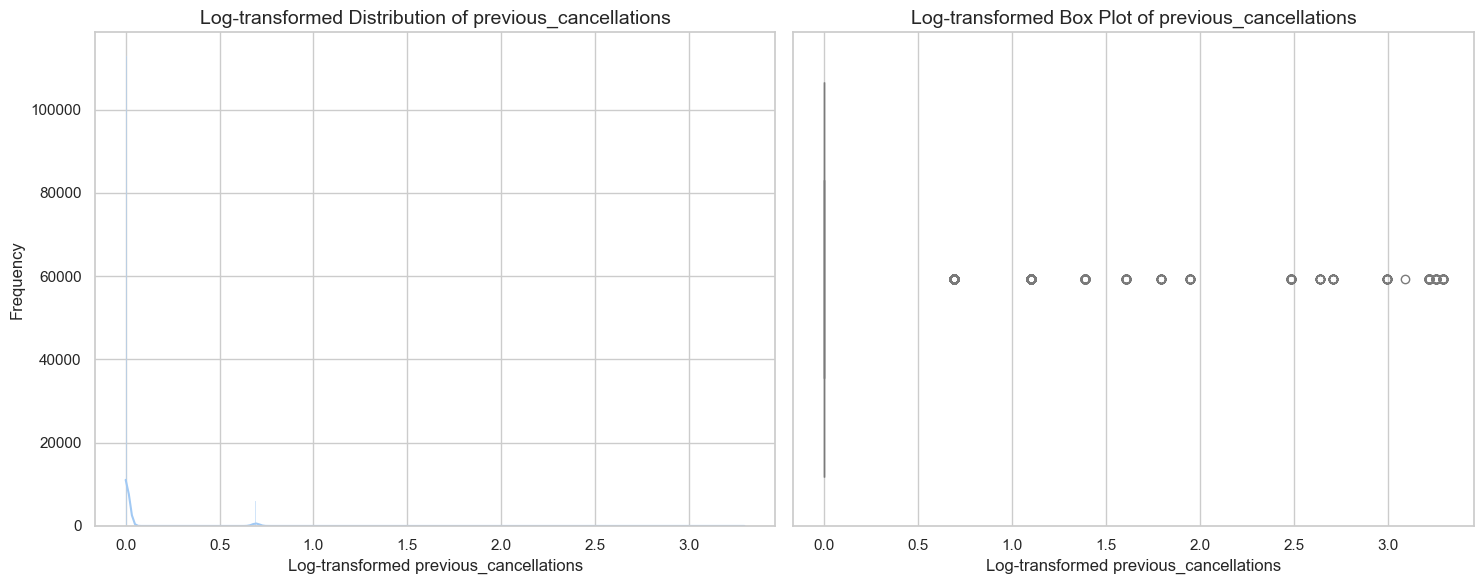

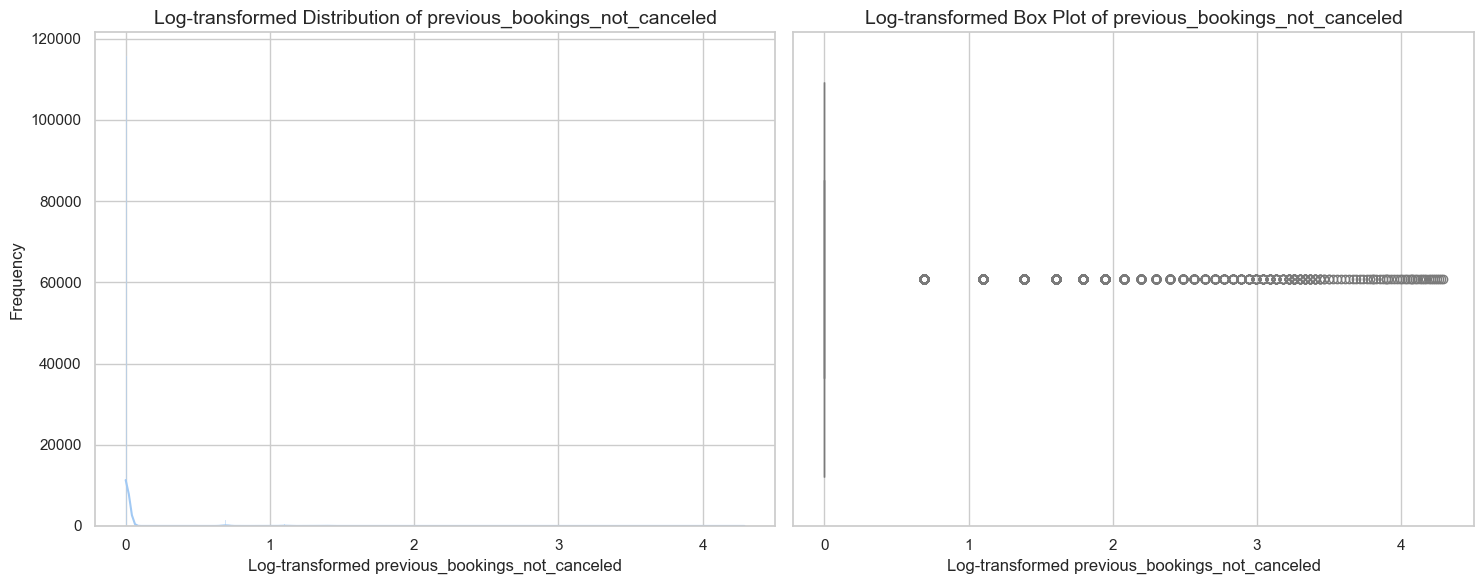

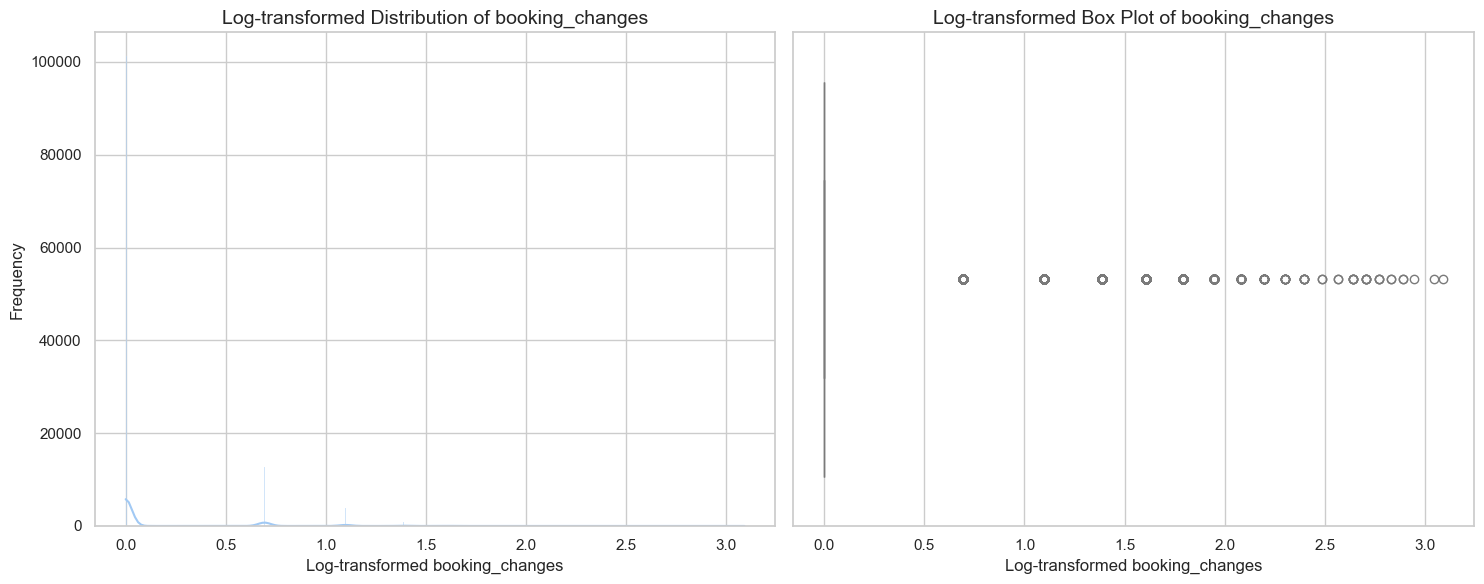

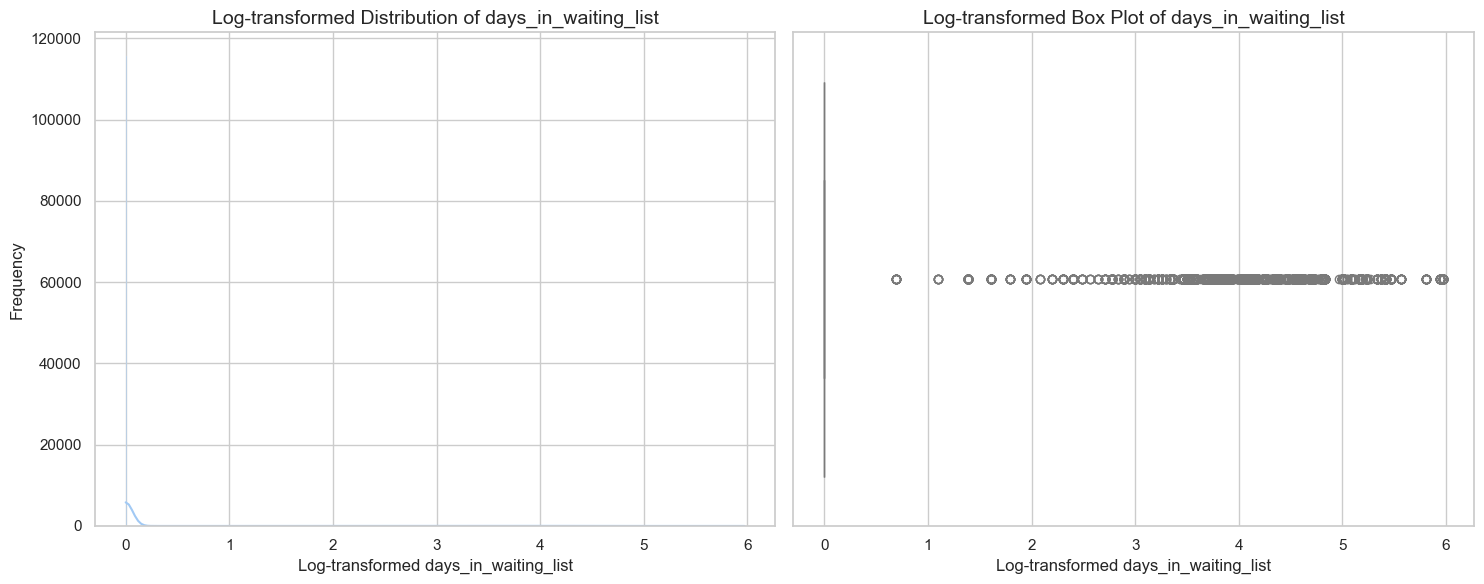

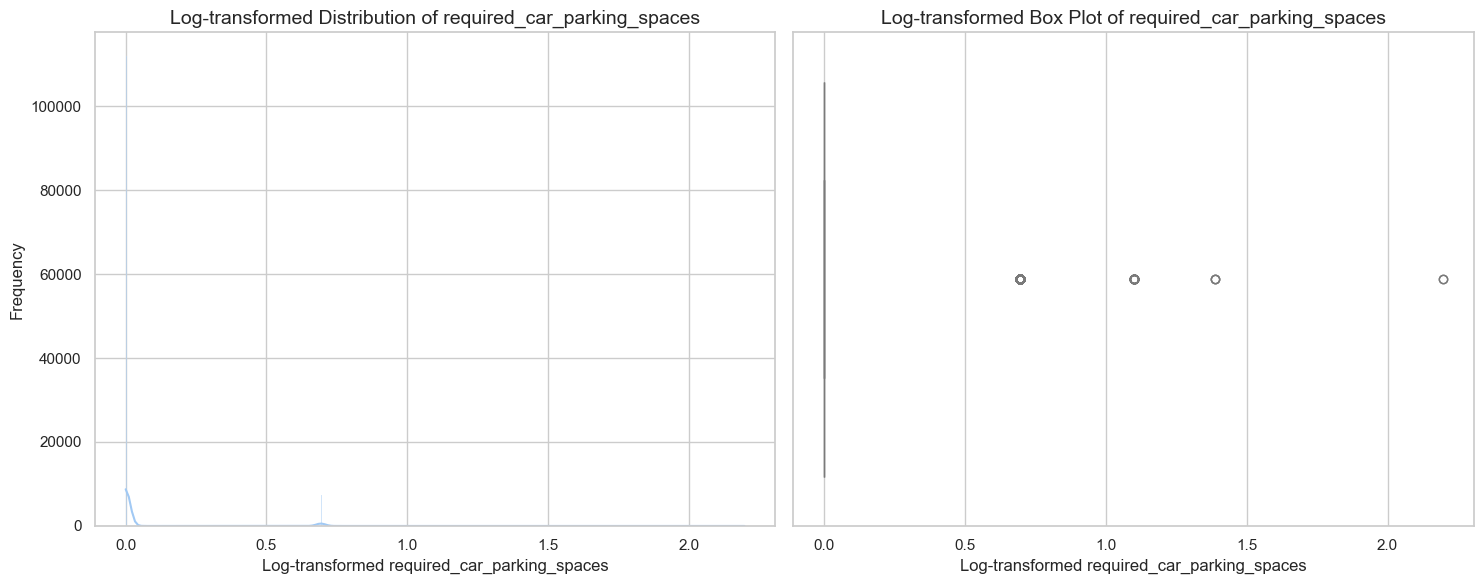

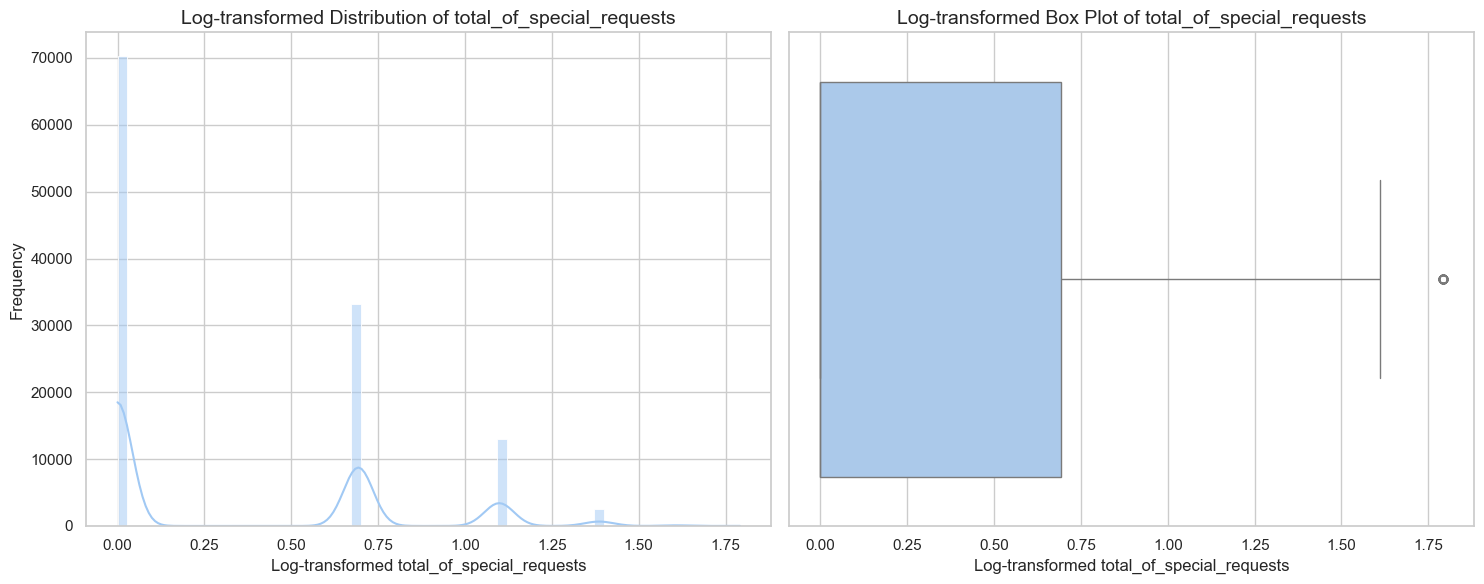

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Place your data loading code here to create the 'df' DataFrame
# Example: df = pd.read_csv('your_file_name.csv')

# List of numerical columns to plot with log transformation
num_cols = [
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests'
]

# Set the visualization style
sns.set(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (15, 6)

# Loop through each numerical column and create a histogram and a box plot
for col in num_cols:
    # Check if the column exists and handle potential negative values
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame. Skipping.")
        continue
    
    # Check for negative values, which are not valid for log transformation
    if (df[col] < 0).any():
        print(f"Warning: Column '{col}' contains negative values. Log transformation skipped for this column.")
        continue

    # Apply log transformation using np.log1p to handle zero values
    # We take a copy to avoid modifying the original DataFrame
    log_transformed = np.log1p(df[col])

    # Create the plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot a histogram to show the distribution
    sns.histplot(x=log_transformed, kde=True, ax=axes[0])
    axes[0].set_title(f'Log-transformed Distribution of {col}', fontsize=14)
    axes[0].set_xlabel(f'Log-transformed {col}', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)

    # Plot a box plot to show outliers
    sns.boxplot(x=log_transformed, ax=axes[1])
    axes[1].set_title(f'Log-transformed Box Plot of {col}', fontsize=14)
    axes[1].set_xlabel(f'Log-transformed {col}', fontsize=12)

    plt.tight_layout()
    plt.show()

상관관계

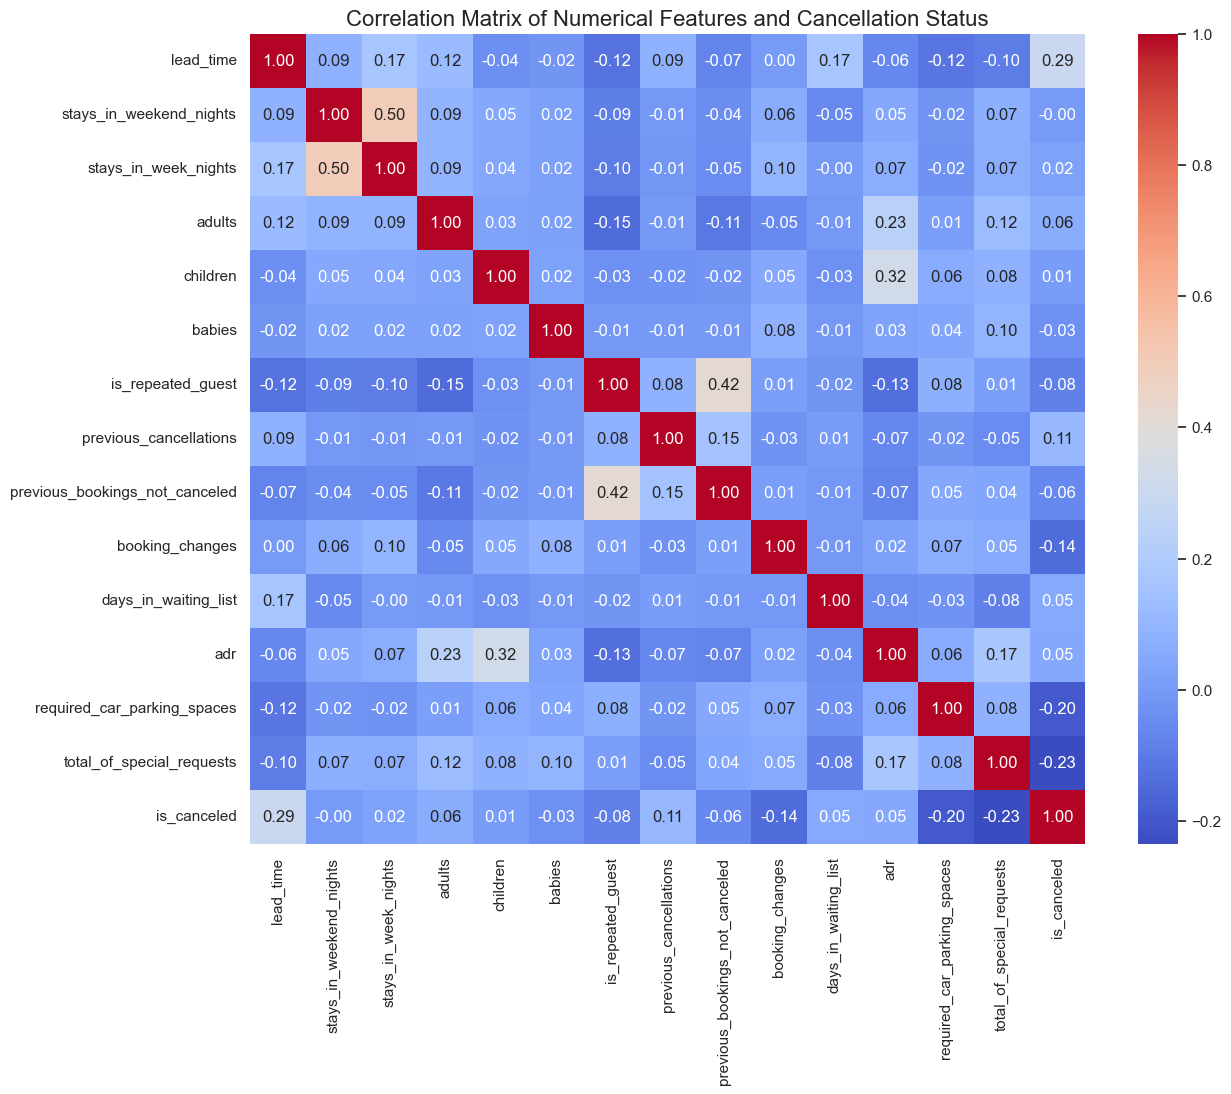

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 분석할 수치형 변수 리스트
num_cols = [
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'booking_changes',
    'days_in_waiting_list',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled'  # 타겟 변수도 포함
]

# 상관관계 행렬 계산
corr_matrix = df[num_cols].corr()

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Cancellation Status', fontsize=16)
plt.show()

<Figure size 800x600 with 0 Axes>

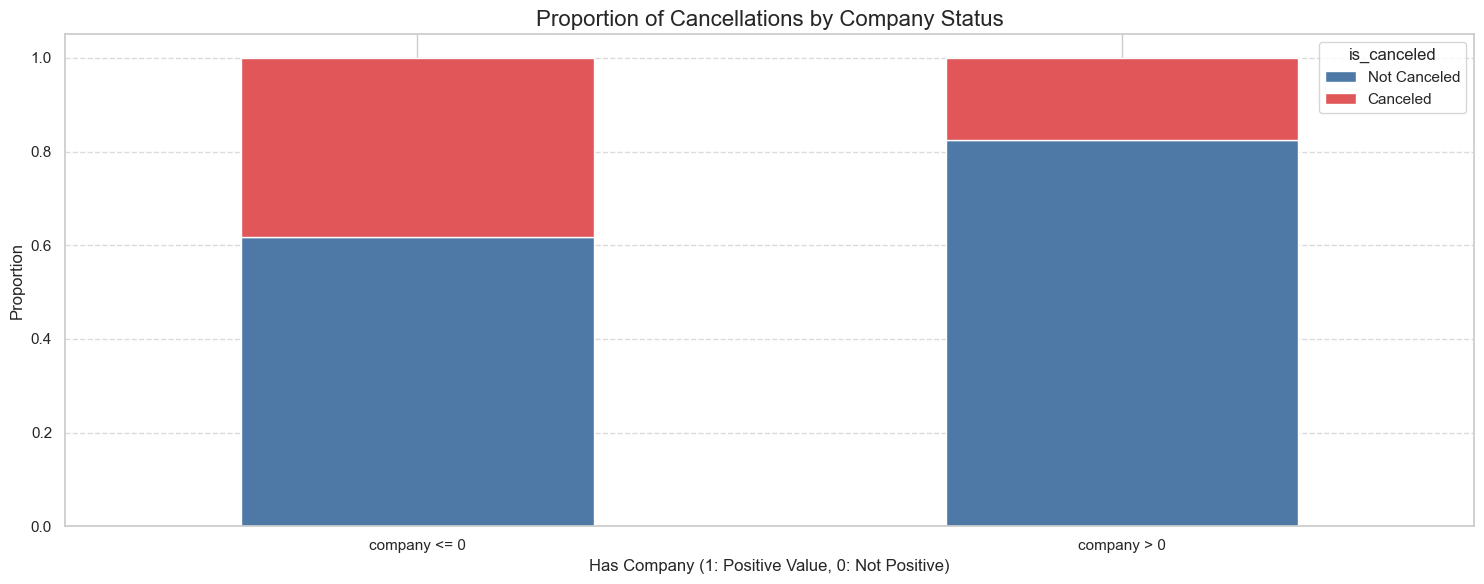

In [20]:
df['has_company'] = (df['company'] > 0).astype(int)

# 3. 데이터 집계
# 'has_company'와 'is_canceled'를 기준으로 그룹화하고, 각 그룹의 개수를 계산
df_agg = df.groupby(['has_company', 'is_canceled']).size().unstack(fill_value=0)

# 4. 누적 비율 계산
# 각 행의 합을 기준으로 비율로 변환하여, 그래프의 높이를 1로 통일
df_prop = df_agg.div(df_agg.sum(axis=1), axis=0)

# 5. 누적 막대 그래프 시각화
plt.figure(figsize=(8, 6))
df_prop.plot(kind='bar', stacked=True, color=['#4E79A7', '#E15759'])

plt.title('Proportion of Cancellations by Company Status', fontsize=16)
plt.xlabel('Has Company (1: Positive Value, 0: Not Positive)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['company <= 0', 'company > 0'], rotation=0)
plt.legend(title='is_canceled', labels=['Not Canceled', 'Canceled'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

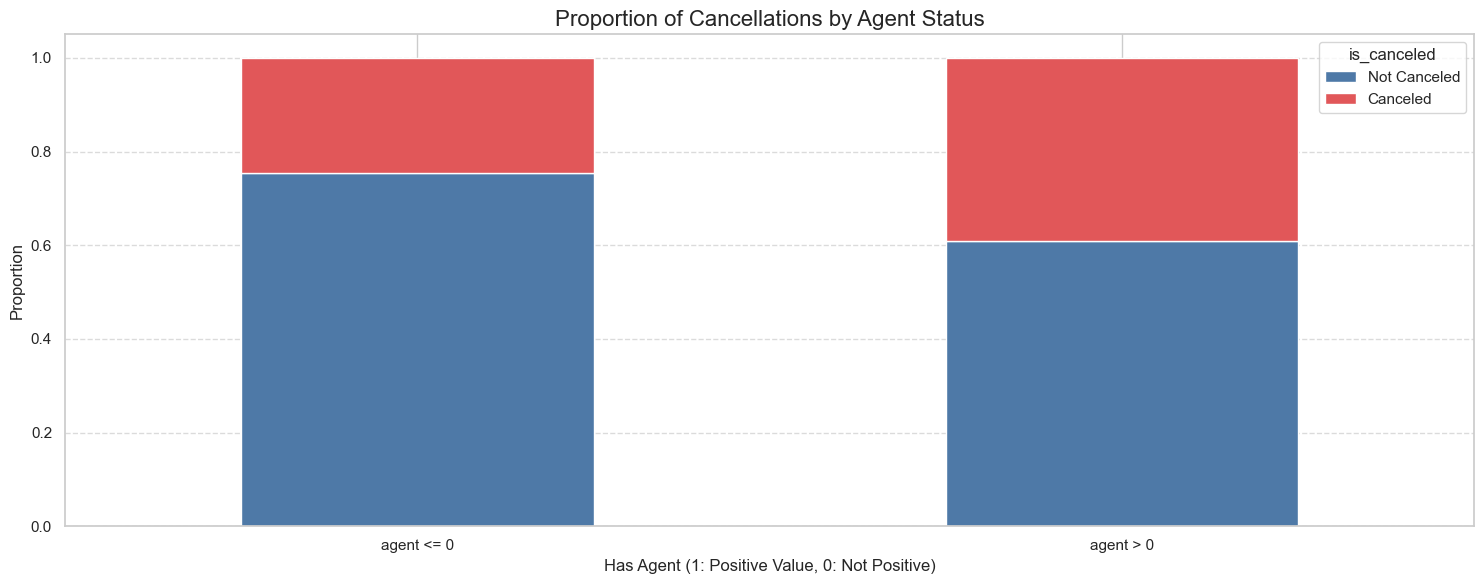

In [21]:
# 2. 'has_agent' 피쳐 생성
# 'agent' 컬럼의 값이 0보다 크면 1, 아니면 0으로 변환
df['has_agent'] = (df['agent'] > 0).astype(int)

# 3. 데이터 집계
# 'has_agent'와 'is_canceled'를 기준으로 그룹화하여 각 그룹의 개수 계산
df_agg = df.groupby(['has_agent', 'is_canceled']).size().unstack(fill_value=0)

# 4. 누적 비율 계산
# 각 행의 총합을 기준으로 비율로 변환
df_prop = df_agg.div(df_agg.sum(axis=1), axis=0)

# 5. 누적 막대 그래프 시각화
plt.figure(figsize=(8, 6))
df_prop.plot(kind='bar', stacked=True, color=['#4E79A7', '#E15759'])

plt.title('Proportion of Cancellations by Agent Status', fontsize=16)
plt.xlabel('Has Agent (1: Positive Value, 0: Not Positive)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['agent <= 0', 'agent > 0'], rotation=0)
plt.legend(title='is_canceled', labels=['Not Canceled', 'Canceled'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

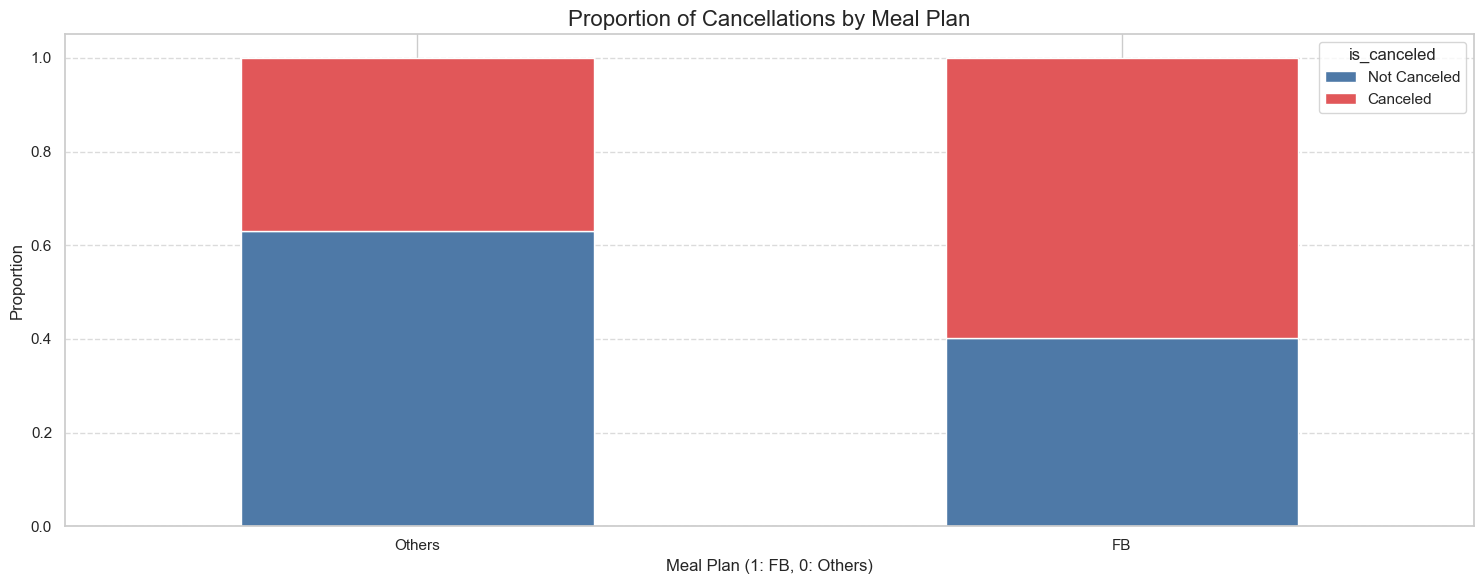

In [22]:
# 2. 'is_fb_meal' 피처 생성
# 'meal' 컬럼의 값이 'FB'이면 1, 아니면 0으로 변환
df['is_fb_meal'] = (df['meal'] == 'FB').astype(int)

# 3. 데이터 집계
# 'is_fb_meal'와 'is_canceled'를 기준으로 그룹화하여 각 그룹의 개수 계산
df_agg = df.groupby(['is_fb_meal', 'is_canceled']).size().unstack(fill_value=0)

# 4. 누적 비율 계산
# 각 행의 총합을 기준으로 비율로 변환
df_prop = df_agg.div(df_agg.sum(axis=1), axis=0)

# 5. 누적 막대 그래프 시각화
plt.figure(figsize=(8, 6))
df_prop.plot(kind='bar', stacked=True, color=['#4E79A7', '#E15759'])

plt.title('Proportion of Cancellations by Meal Plan', fontsize=16)
plt.xlabel('Meal Plan (1: FB, 0: Others)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Others', 'FB'], rotation=0)
plt.legend(title='is_canceled', labels=['Not Canceled', 'Canceled'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

✓ 'is_high_risk_market' 피처 생성이 완료되었습니다.


<Figure size 800x600 with 0 Axes>

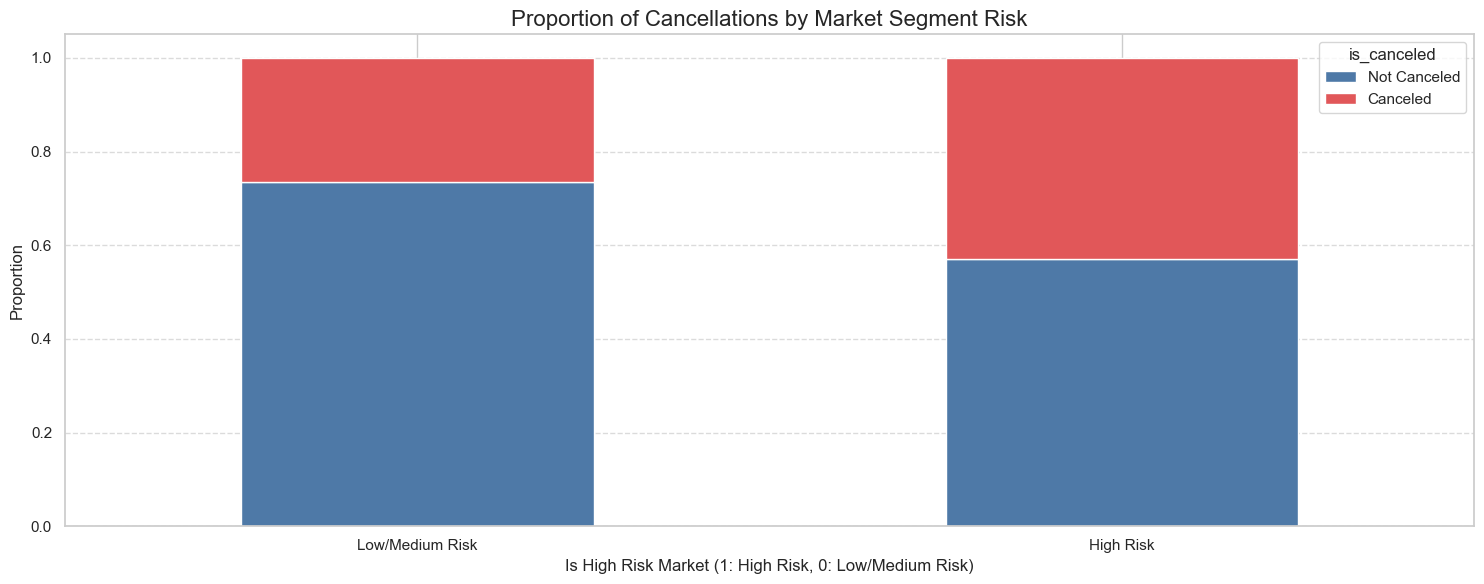

In [28]:
# 2. 'is_high_risk_market' 피처 생성
market_risk_mapping = {
    'Groups': 'High risk',
    'Online TA': 'High risk',
    'Offline TA/TO': 'Medium risk',
    'Direct': 'Low risk',
    'Corporate': 'Low risk',
    'Complementary': 'Low risk'
}
high_risk_segments = [segment for segment, risk in market_risk_mapping.items() if risk == 'High risk']

if 'market_segment' in df.columns: # 'df'를 실제 변수명으로 변경해야 합니다.
    df['is_high_risk_market'] = df['market_segment'].isin(high_risk_segments).astype(int)
    print("✓ 'is_high_risk_market' 피처 생성이 완료되었습니다.")
else:
    print("Error: 'market_segment' 컬럼을 데이터프레임에서 찾을 수 없습니다.")

# 3. 데이터 집계
df_agg = df.groupby(['is_high_risk_market', 'is_canceled']).size().unstack(fill_value=0)

# 4. 누적 비율 계산
df_prop = df_agg.div(df_agg.sum(axis=1), axis=0)

# 5. 누적 막대 그래프 시각화
plt.figure(figsize=(8, 6))
df_prop.plot(kind='bar', stacked=True, color=['#4E79A7', '#E15759'])

plt.title('Proportion of Cancellations by Market Segment Risk', fontsize=16)
plt.xlabel('Is High Risk Market (1: High Risk, 0: Low/Medium Risk)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Low/Medium Risk', 'High Risk'], rotation=0)
plt.legend(title='is_canceled', labels=['Not Canceled', 'Canceled'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- IQR 기반 ADR 처리 결과 ---


<Figure size 800x600 with 0 Axes>

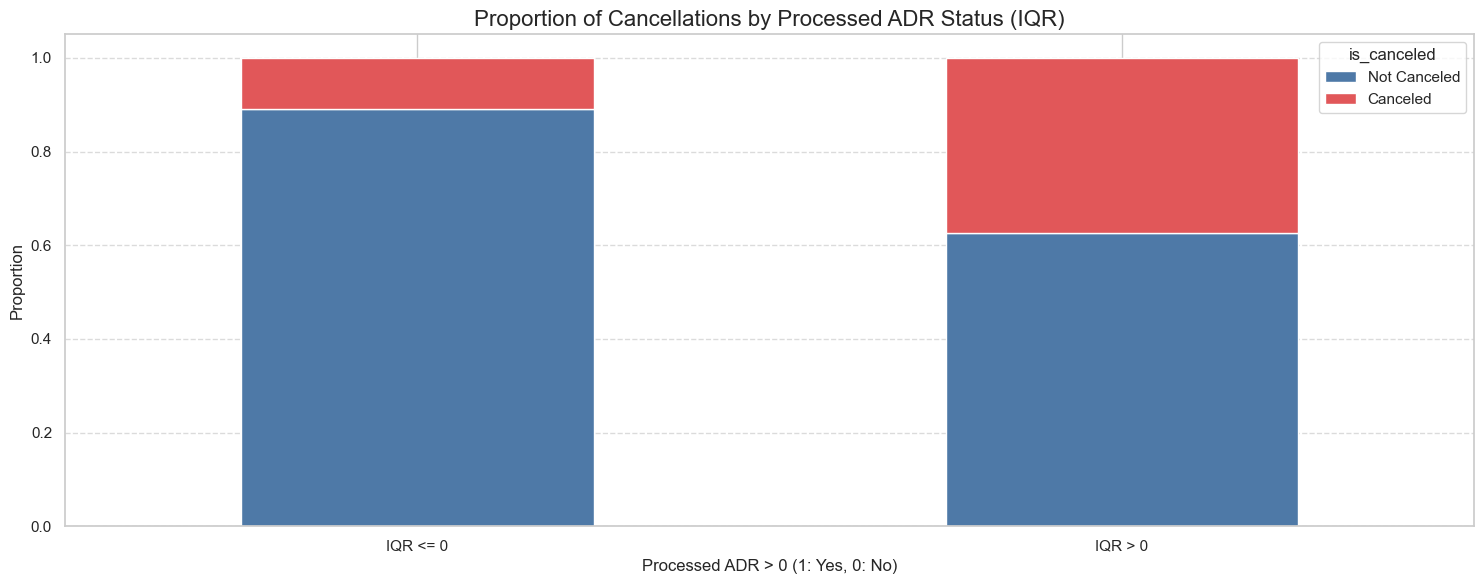


--- 특정 값 기준 ADR 처리 결과 ---


<Figure size 800x600 with 0 Axes>

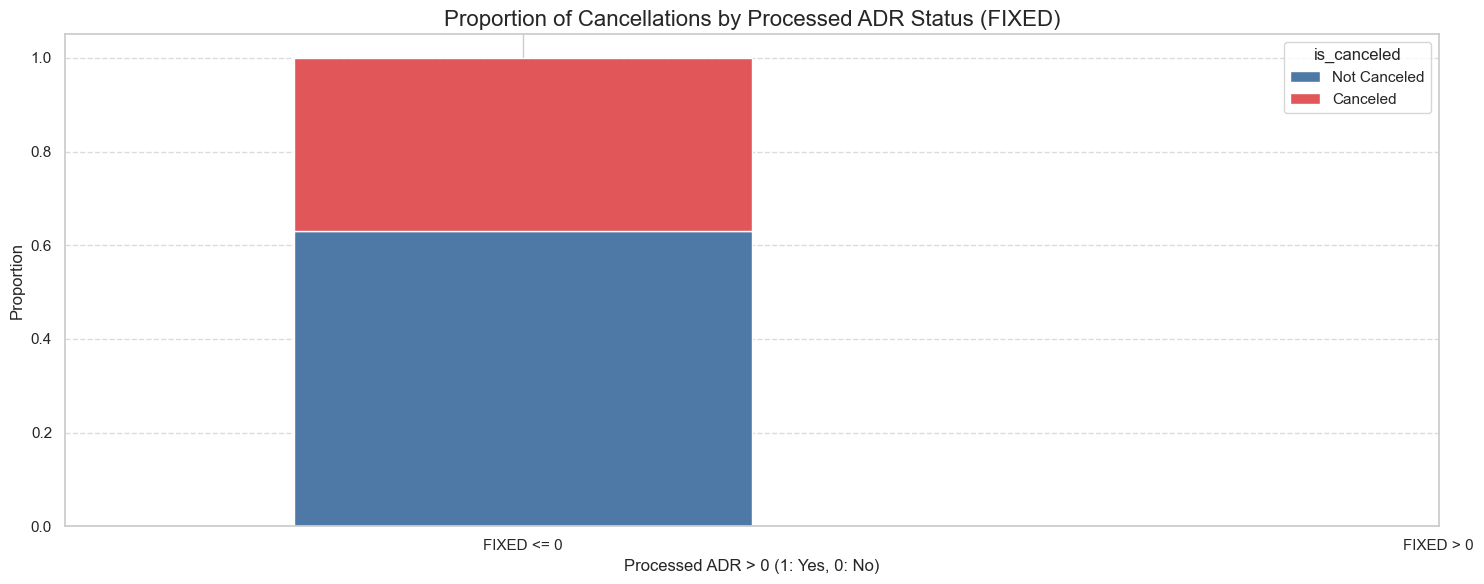

In [30]:
# 2. 첫 번째 방법: IQR을 활용한 이상치 처리 및 새로운 피처 생성
Q1 = df['adr'].quantile(0.25)
Q3 = df['adr'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

adr_filtered_median = df.loc[(df['adr'] >= lower_bound) & (df['adr'] <= upper_bound), 'adr'].median()
df['adr_processed_iqr'] = np.where(
    (df['adr'] < lower_bound) | (df['adr'] > upper_bound),
    adr_filtered_median,
    df['adr']
)

# 3. 두 번째 방법: 특정 값(1과 200)을 기준으로 한 이상치 처리 및 새로운 피처 생성
adr_median = df['adr'].median()
df['adr_processed_fixed'] = np.where(
    (df['adr'] < 1) | (df['adr'] > 200),
    adr_median,
    df['adr']
)

# 4. 누적 그래프 시각화 함수 정의
def plot_stacked_by_adr_processing(dataframe, processed_column):
    """
    처리된 adr 피처를 기준으로 is_canceled와의 관계를 누적 막대 그래프로 시각화합니다.
    """
    # adr 값이 0보다 크면 1, 아니면 0인 피처 생성
    dataframe[f'{processed_column}_positive'] = (dataframe[processed_column] > 0).astype(int)

    # 데이터 집계
    df_agg = dataframe.groupby([f'{processed_column}_positive', 'is_canceled']).size().unstack(fill_value=0)

    # 누적 비율 계산
    df_prop = df_agg.div(df_agg.sum(axis=1), axis=0)

    # 누적 막대 그래프 시각화
    plt.figure(figsize=(8, 6))
    df_prop.plot(kind='bar', stacked=True, color=['#4E79A7', '#E15759'])

    plt.title(f'Proportion of Cancellations by Processed ADR Status ({processed_column.split("_")[2].upper()})', fontsize=16)
    plt.xlabel('Processed ADR > 0 (1: Yes, 0: No)', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=[f'{processed_column.split("_")[2].upper()} <= 0', f'{processed_column.split("_")[2].upper()} > 0'], rotation=0)
    plt.legend(title='is_canceled', labels=['Not Canceled', 'Canceled'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    # 5. 각 처리 방법에 대한 누적 그래프 생성
print("--- IQR 기반 ADR 처리 결과 ---")
plot_stacked_by_adr_processing(df, 'adr_processed_iqr')

print("\n--- 특정 값 기준 ADR 처리 결과 ---")
plot_stacked_by_adr_processing(df, 'adr_processed_fixed')